# Importings

In [91]:
import pandas as pd                                    # for data
import numpy as np                                     # for math
from lightgbm import LGBMRegressor                     # Validation model
from sklearn.metrics import mean_squared_error         # Regressortion metric
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   # for validation
from sklearn.preprocessing import LabelEncoder         # for encoding
import sklearn.manifold._t_sne as tsne                 # for t_sne
import seaborn as sns                     
from sklearn.model_selection import TimeSeriesSplit# for plotting
import matplotlib.pyplot as plt    
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb 
train = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Train.csv') 
test = pd.read_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/data/Test.csv')

test_id = test['ID_Zindi']
pd.options.display.max_columns = 200
train,test = reading_data(CFG.data_folder)
target = 'GT_NO2'
groups = train['ID']
test_id = test['ID_Zindi']
train_date = train['Date']
test_date = test['Date']
pd.options.display.max_columns = 200
#train = train.dropna(axis=0)
#test = test.dropna(axis=0)

seed = 7 
seed2 = 77
seed3 = 777
tiney_fraction = 1e-05



In [ ]:
train['ID'].value_counts()
plt.figure(figsize=(25,13))
sns.violinplot(x='ID', y=target, data=train)
plt.title('Target Variable Distribution by ID (Violinplot)')
plt.show()


plt.figure()
plt.figure(figsize=(23,13))
sns.boxplot(x='ID', y=target, data=train)
plt.title('Target Variable Distribution by ID (Boxplot)')
plt.show()

In [92]:
train.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


# Target Analysis

In [ ]:
train['GT_NO2'].plot(kind='hist',
                     figsize=(16,8),
                     bins=500)

# Exploratoray Data Analysis

In [94]:
train.describe()

,LAT,LON,Precipitation,LST,AAI,CloudFraction,NO2_strat,NO2_total,NO2_trop,TropopausePressure,GT_NO2
count,86584.000000,86584.000000,86584.000000,46798.000000,73709.000000,73709.000000,73709.000000,73709.000000,51111.000000,73709.000000,82051.000000
mean,45.421456,10.014272,2.585528,299.268841,-1.274999,0.200606,0.000045,0.000156,0.000105,16655.112392,24.535051
std,0.225409,1.056637,7.617394,10.927167,0.693003,0.259607,0.000012,0.000103,0.000092,3000.748790,17.108838
min,44.924694,8.736497,0.000000,253.200000,-5.196266,0.000000,0.000013,-0.000012,-0.000025,8614.349685,0.000000
25%,45.249544,9.195325,0.000000,290.920000,-1.749425,0.023900,0.000034,0.000100,0.000047,14432.114060,11.875000
50%,45.478996,9.611738,0.000000,300.760000,-1.349746,0.078478,0.000047,0.000122,0.000071,16711.190570,20.000000
75%,45.601232,10.683357,0.000000,307.940000,-0.878857,0.278451,0.000056,0.000173,0.000129,19252.648570,33.050000
max,45.889734,12.590682,135.396805,327.840000,2.143020,1.000000,0.000073,0.002047,0.001097,24449.007150,188.233333


In [95]:
for col in train.columns: 
    print(col)
    print (train[col].max(), '|',train[col].min())
    print('__________________')

ID_Zindi
ID_ZZZAQB | ID_00017O
__________________
Date
9/9/21 | 1/1/19
__________________
ID
X9999 | PD01
__________________
LAT
45.88973369 | 44.92469405
__________________
LON
12.59068235 | 8.736496578
__________________
Precipitation
135.3968048 | 0.0
__________________
LST
327.84 | 253.2
__________________
AAI
2.143020488 | -5.196266174
__________________
CloudFraction
1.000000044 | 0.0
__________________
NO2_strat
7.28e-05 | 1.34e-05
__________________
NO2_total
0.002047452 | -1.19e-05
__________________
NO2_trop
0.001097291 | -2.53e-05
__________________
TropopausePressure
24449.00715 | 8614.349685
__________________
GT_NO2
188.2333333 | 0.0
__________________


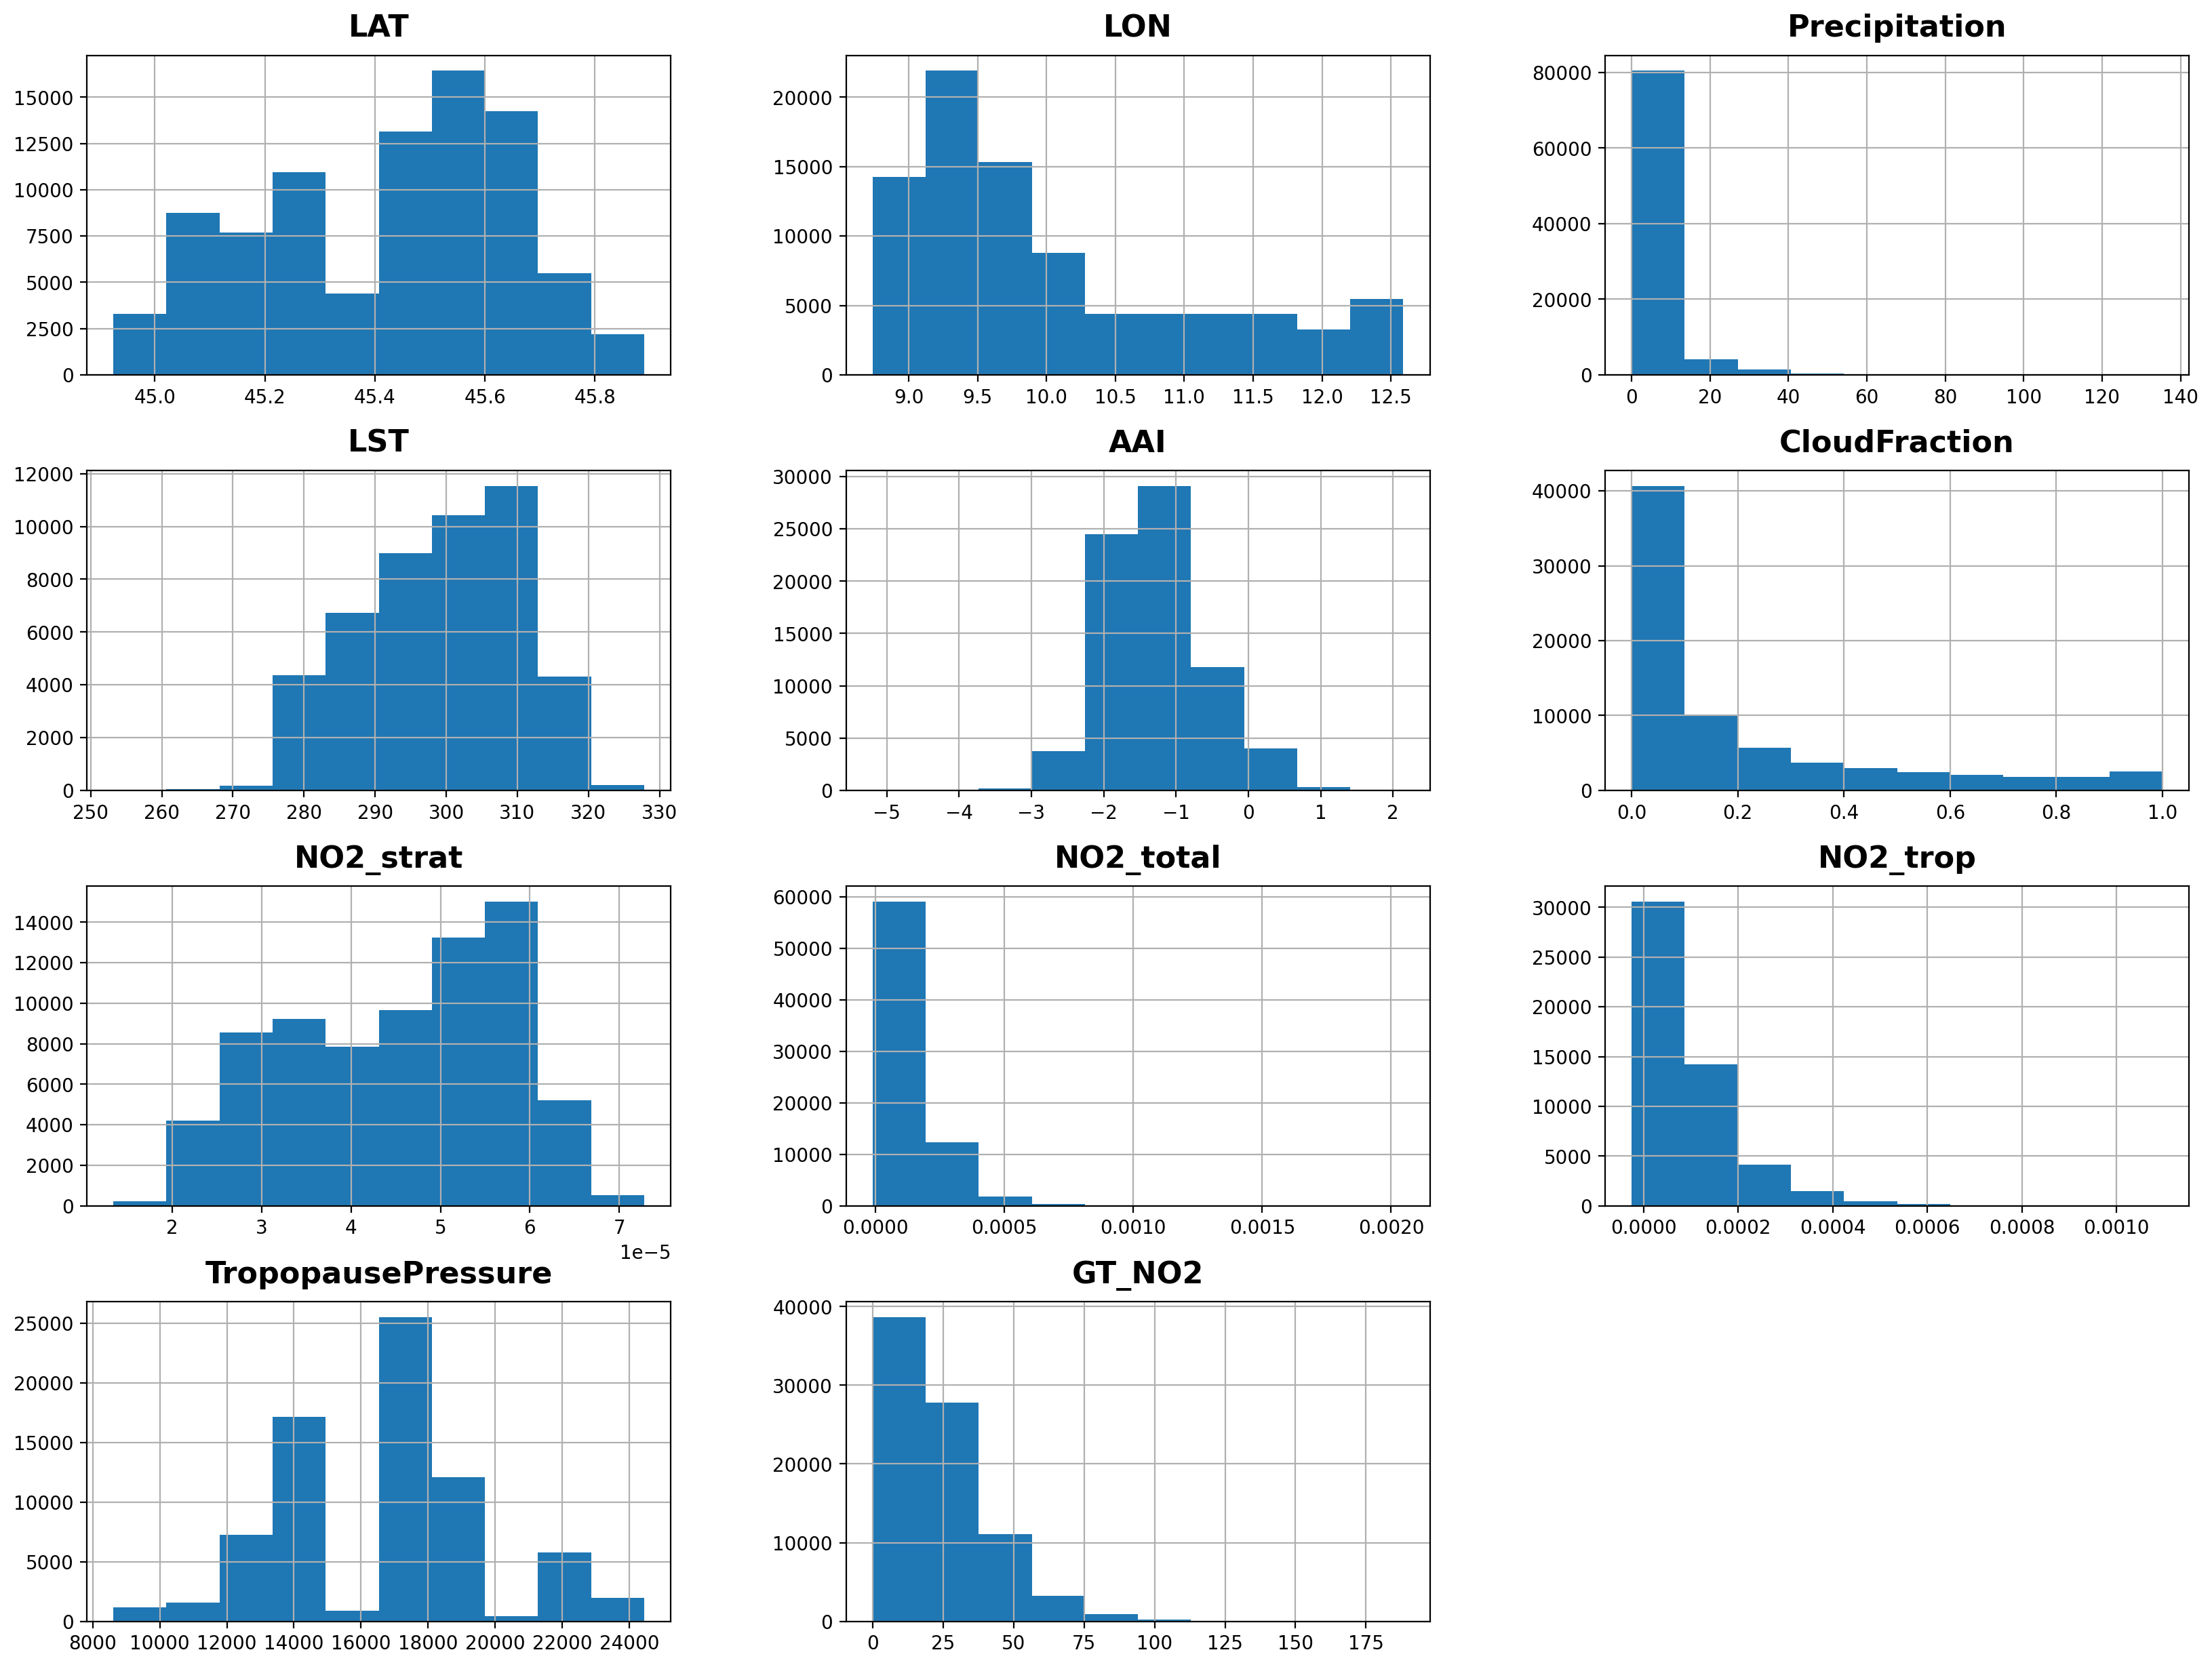

In [96]:
num_feats = list(train.select_dtypes(include=['int64', 'float64', 'int32']).columns)
train[num_feats].hist(figsize=(20,15));

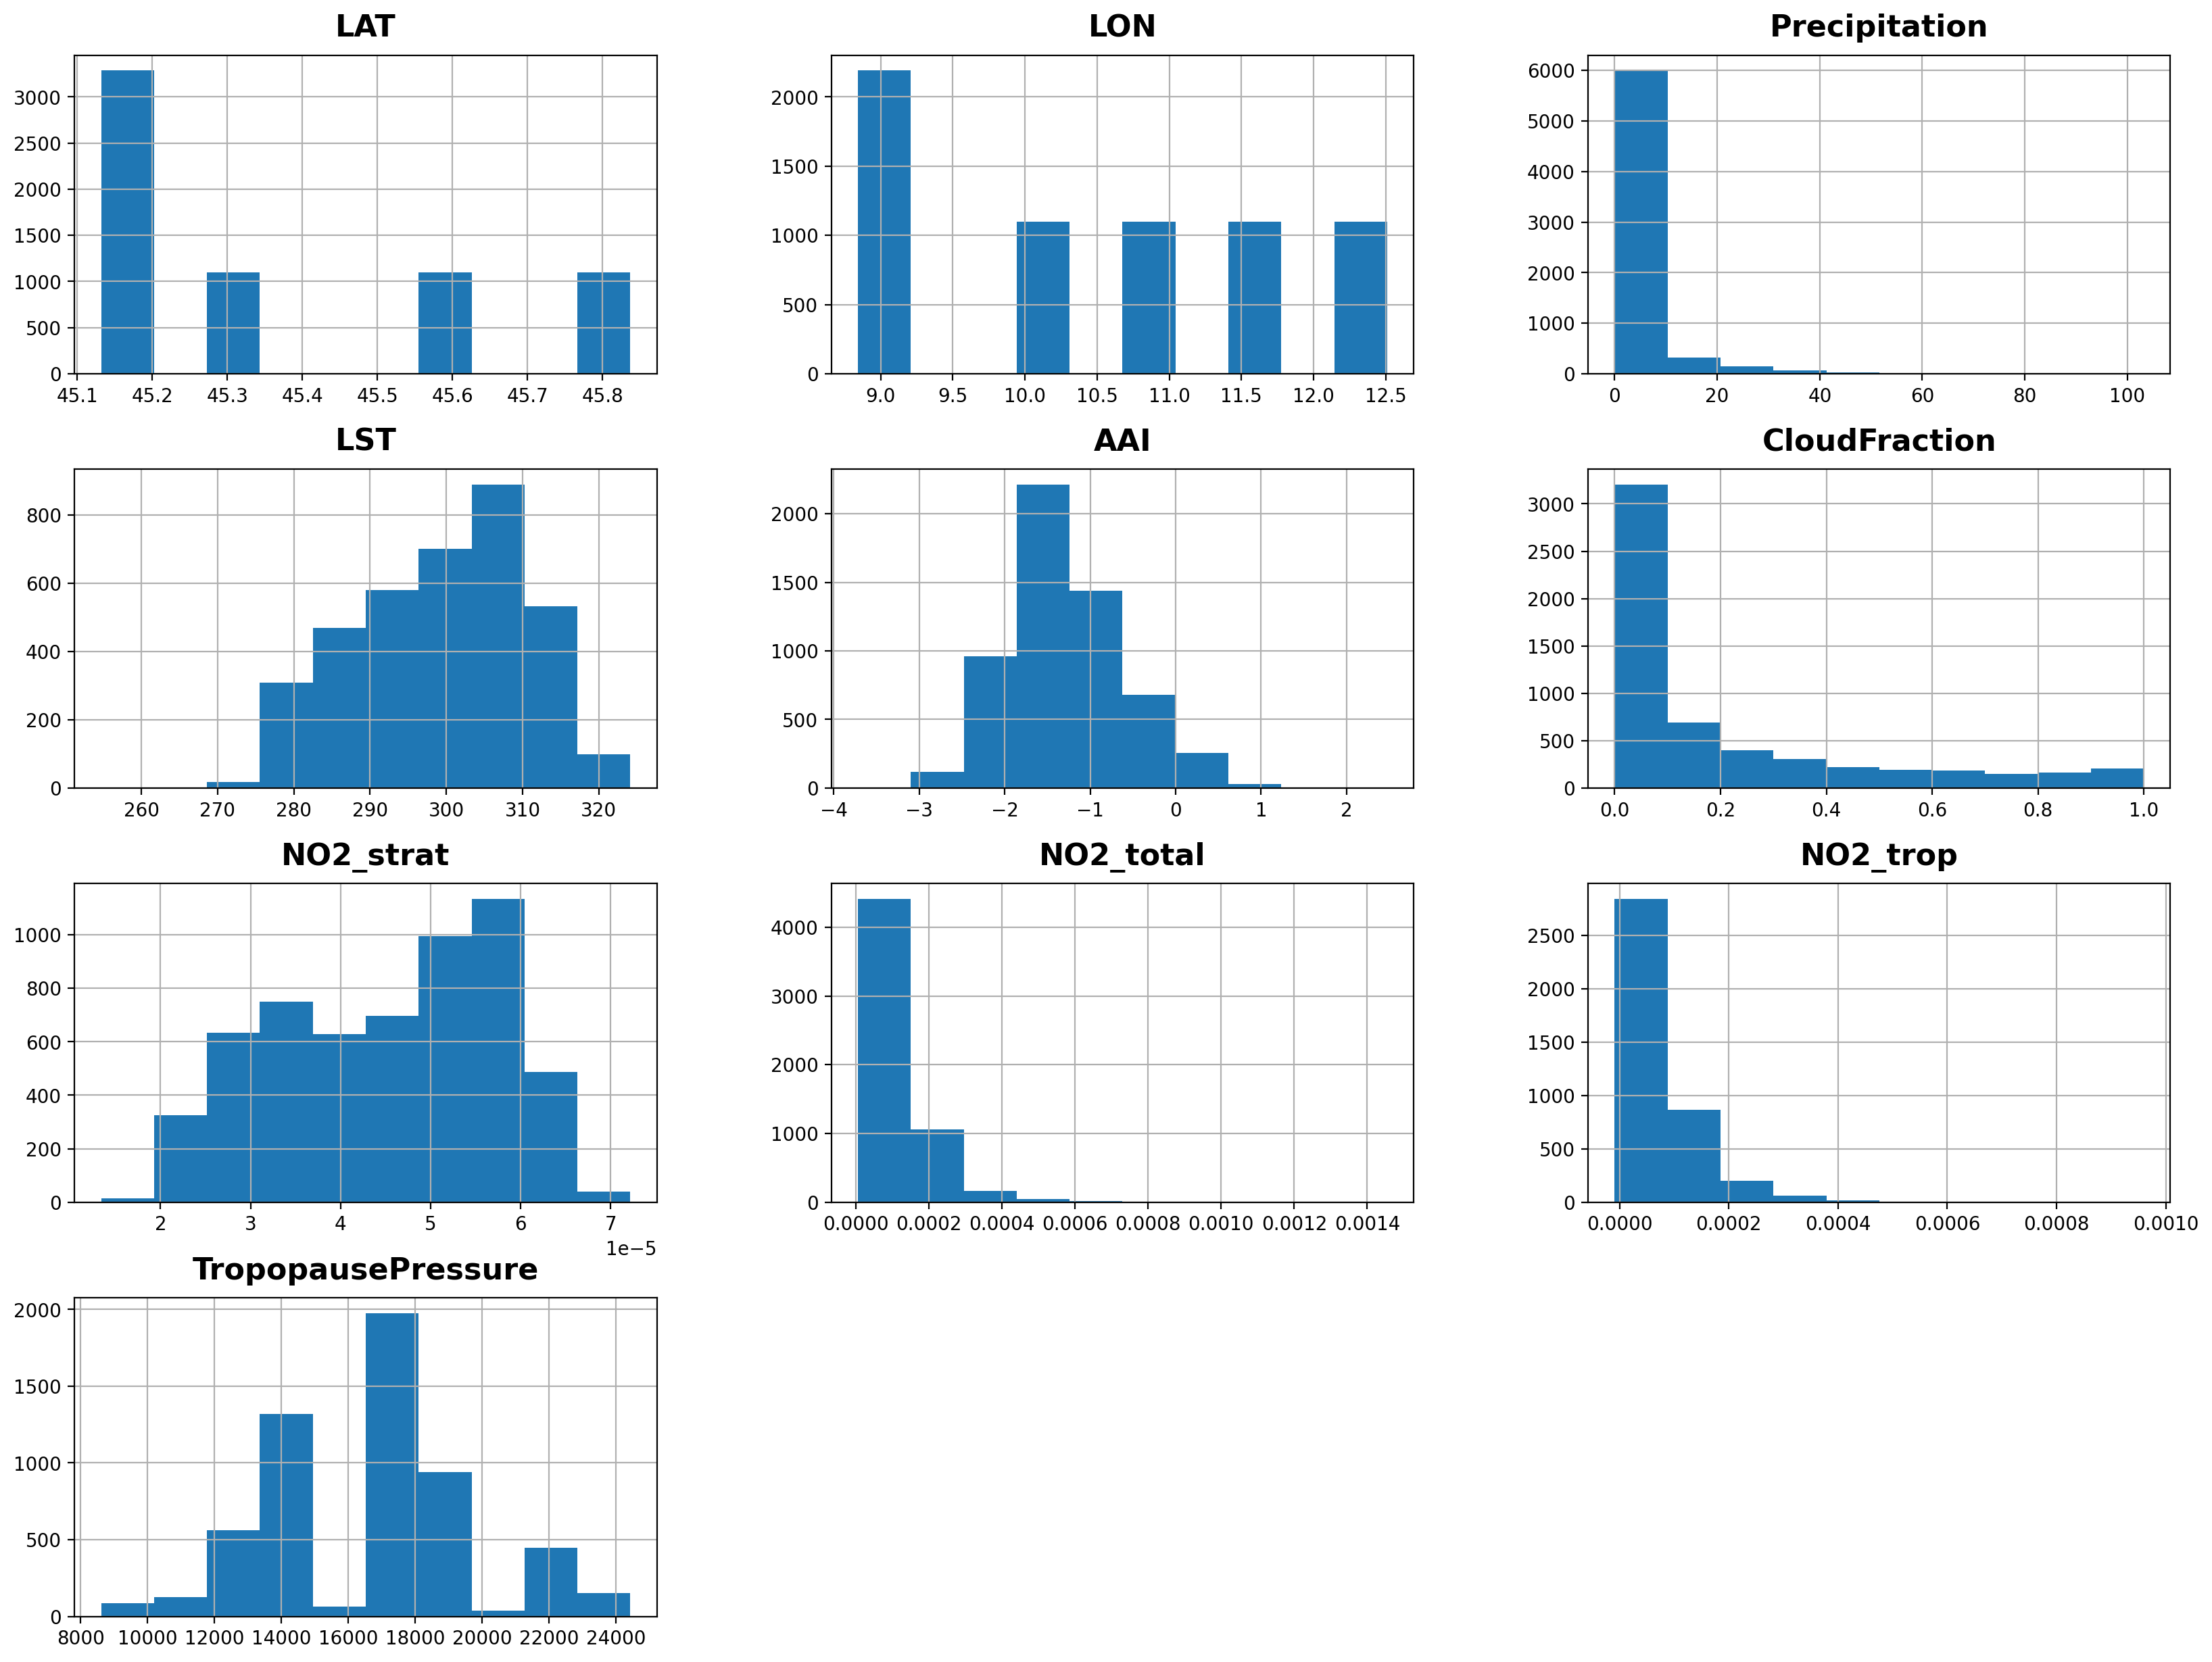

In [97]:
num_feats = list(test.select_dtypes(include=['int64', 'float64', 'int32']).columns)
test[num_feats].hist(figsize=(20,15));

In [98]:
"""attributes = ["NO2_total", "NO2_trop","GT_NO2"]
sns.pairplot(train[attributes], diag_kind="kde")
plt.gcf().set_size_inches(15, 10)"""

'attributes = ["NO2_total", "NO2_trop","GT_NO2"]\nsns.pairplot(train[attributes], diag_kind="kde")\nplt.gcf().set_size_inches(15, 10)'

In [99]:
"""sns.pairplot(train, diag_kind="kde")
plt.gcf().set_size_inches(15, 10)"""

'sns.pairplot(train, diag_kind="kde")\nplt.gcf().set_size_inches(15, 10)'

In [100]:
"""num_feats = train.select_dtypes(include='float')

plt.figure(figsize=(14,6))
sns.pairplot(num_feats)
plt.show()"""

"num_feats = train.select_dtypes(include='float')\n\nplt.figure(figsize=(14,6))\nsns.pairplot(num_feats)\nplt.show()"

<Axes: >

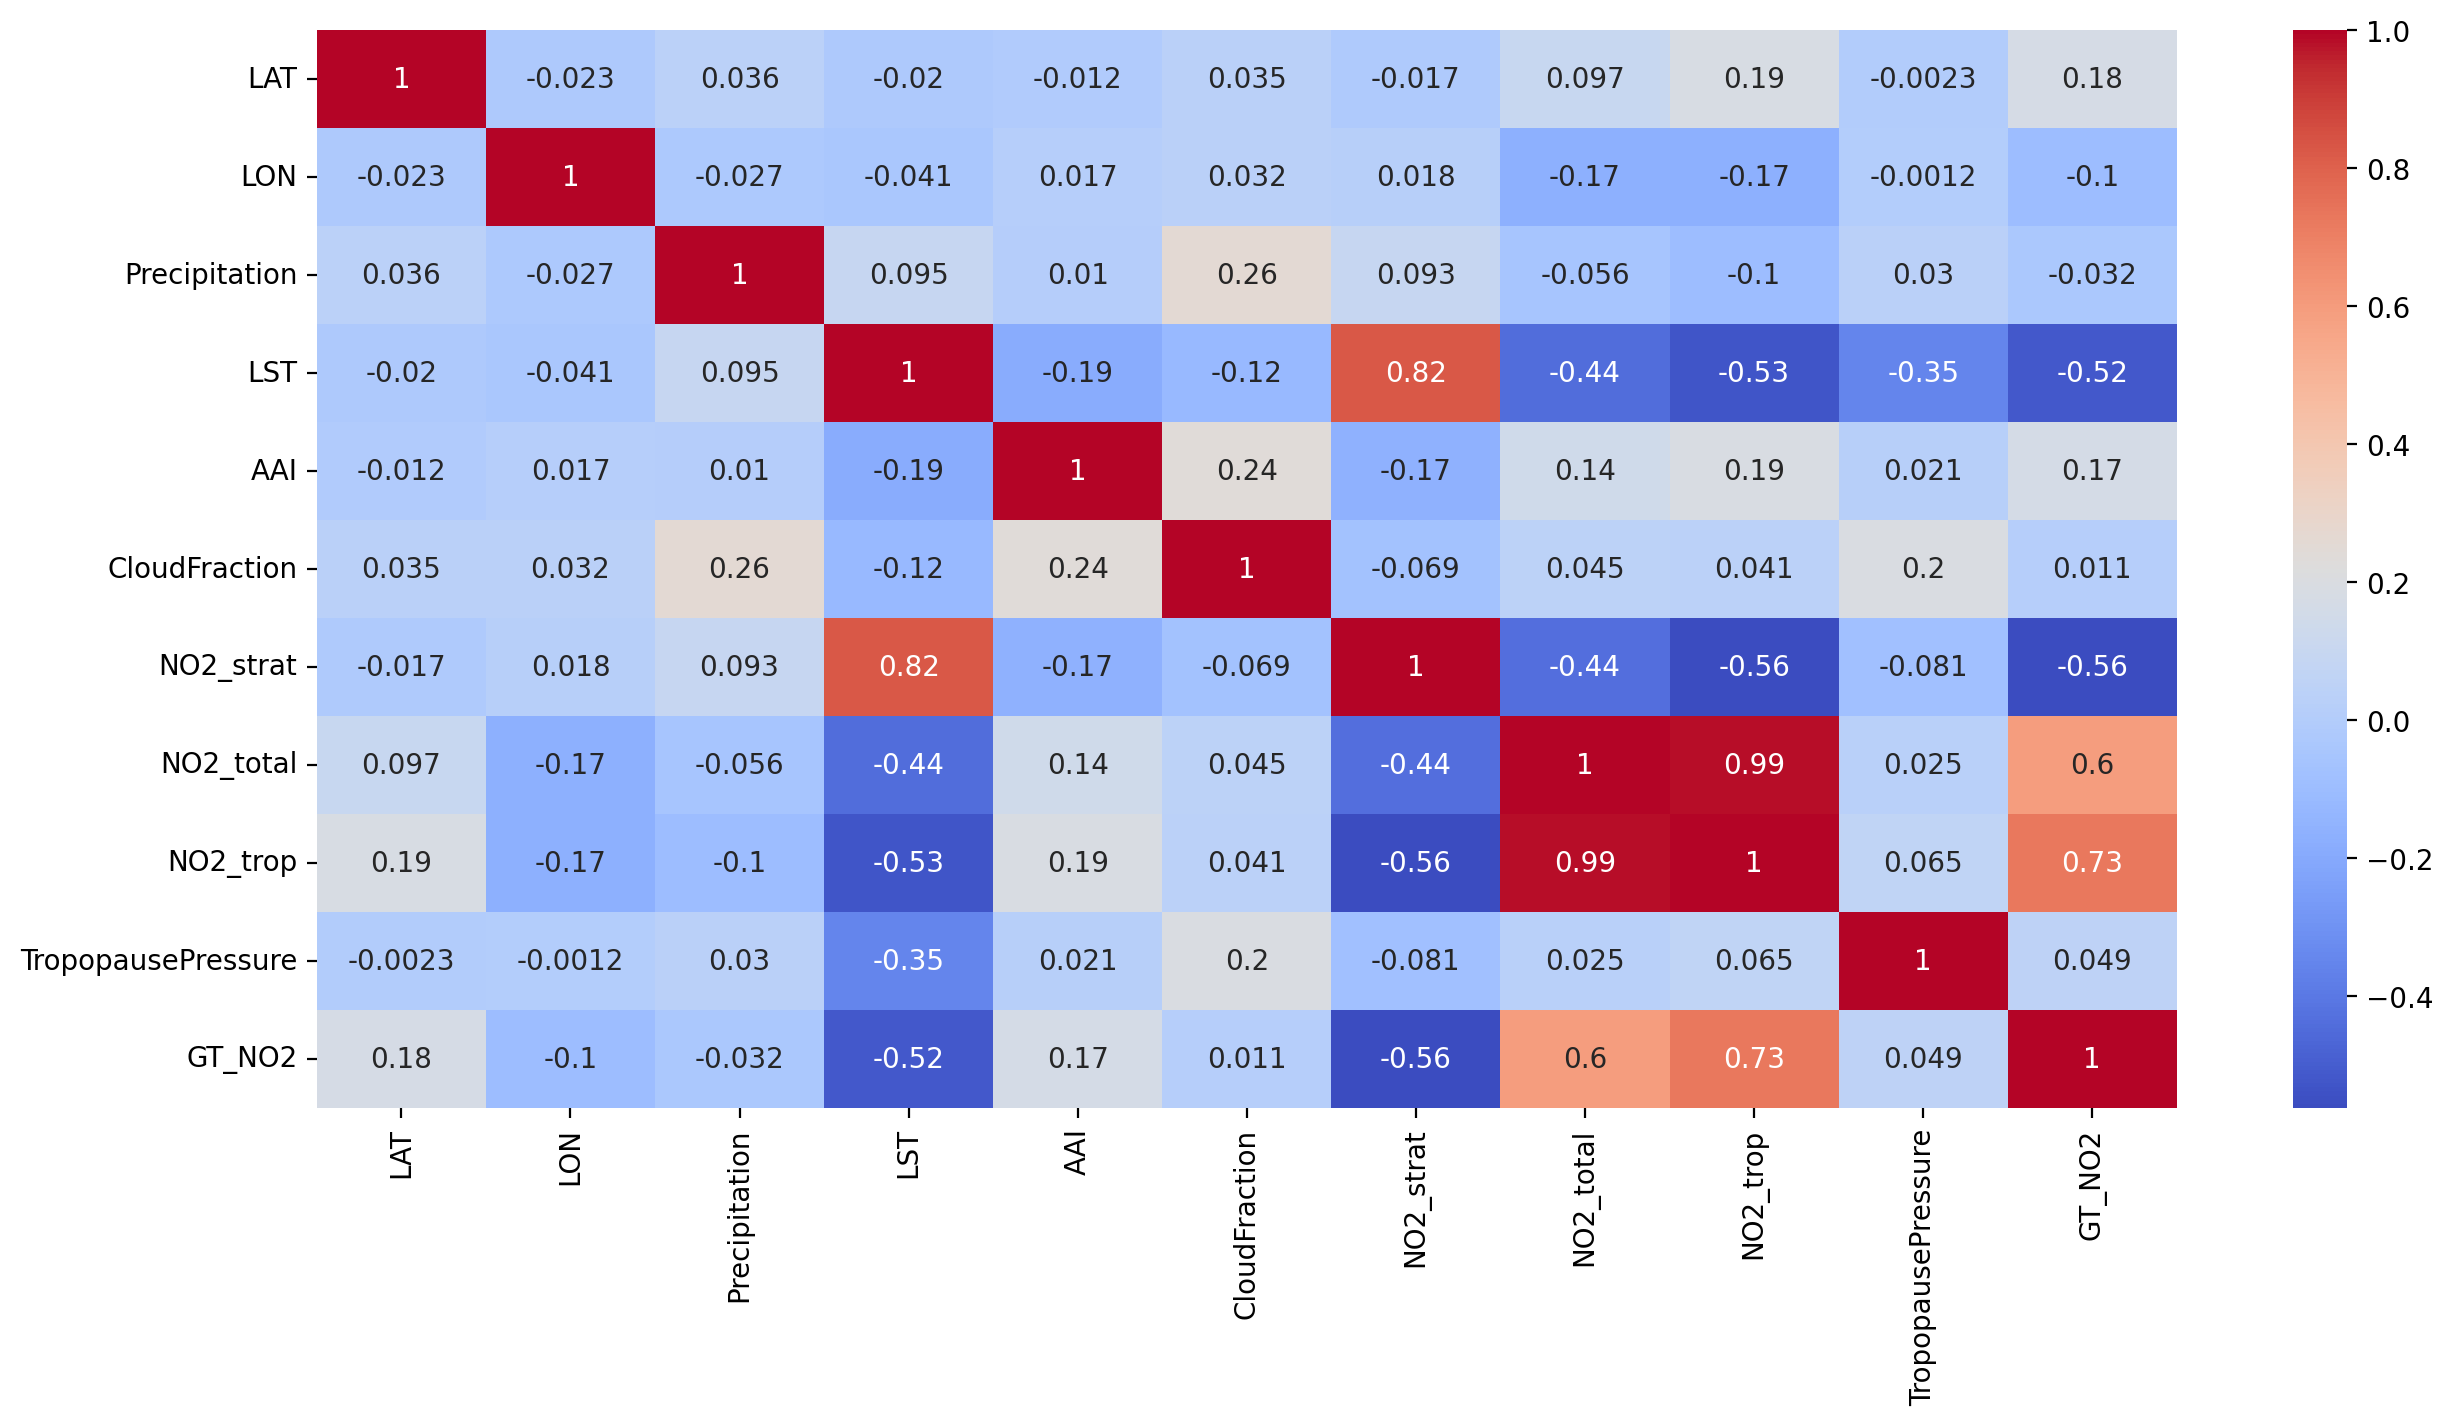

In [101]:
num_feats = train.select_dtypes(include='float')
corrs = num_feats.corr()
plt.figure(figsize=(15,7))
sns.heatmap(corrs, cmap='coolwarm', annot=True)

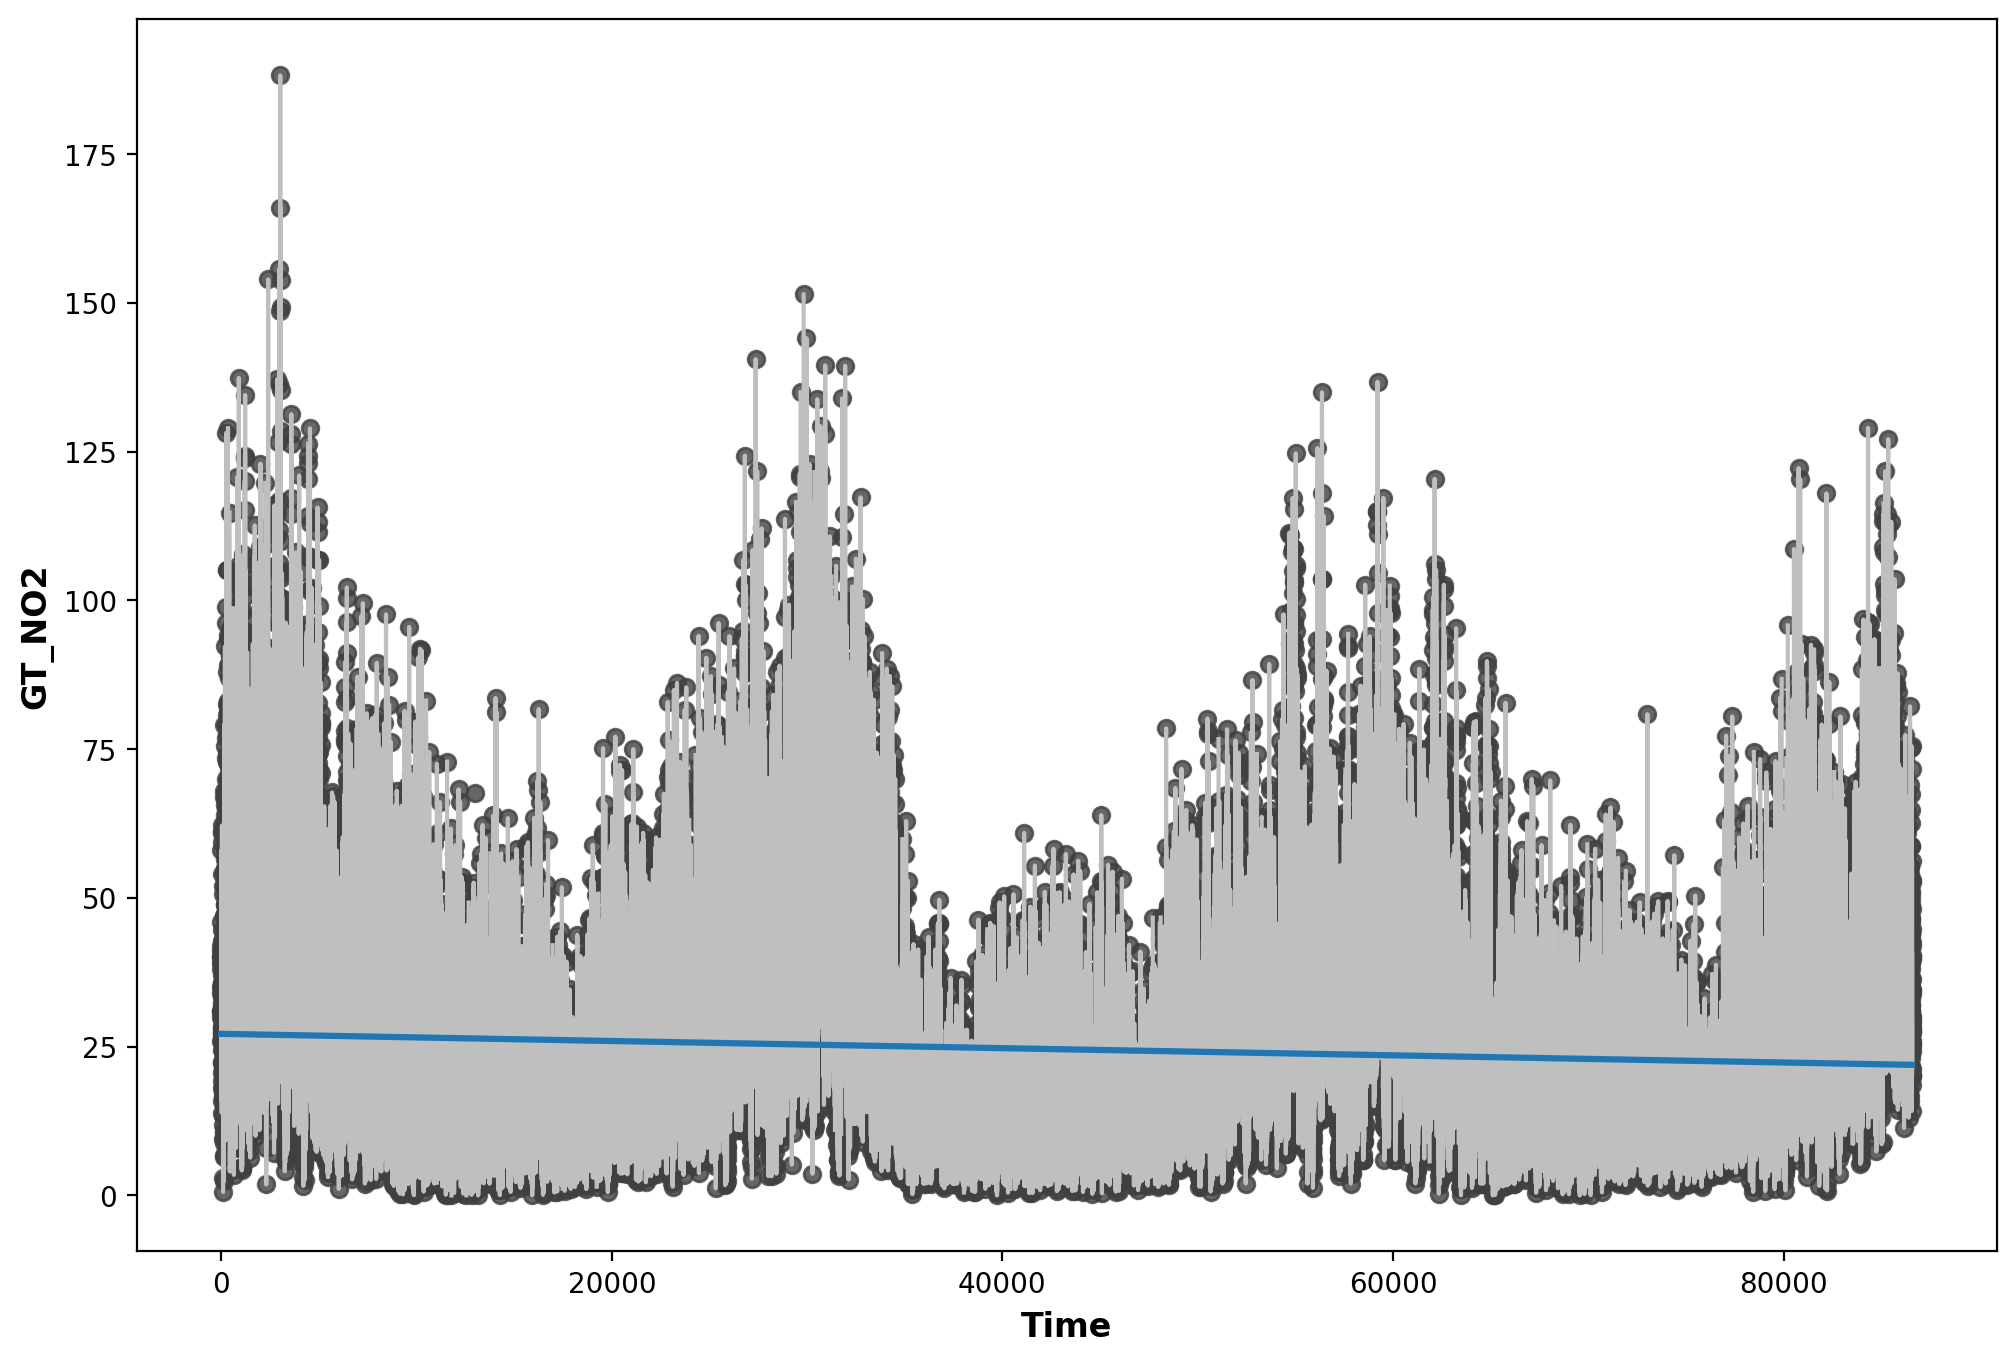

In [102]:
train['Time'] = np.arange(len(train.index))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'GT_NO2', data=train, color='0.75')
ax = sns.regplot(x='Time', y='GT_NO2', data=train, ci=None, scatter_kws=dict(color='0.25'))

# Feature Engineering

In [103]:
num_feats.columns

Index(['LAT', 'LON', 'Precipitation', 'LST', 'AAI', 'CloudFraction',
       'NO2_strat', 'NO2_total', 'NO2_trop', 'TropopausePressure', 'GT_NO2'],
      dtype='object')

In [104]:
train = train.sort_values('Date').reset_index(drop=True) 
test = test.sort_values('Date').reset_index(drop=True)

for df in (train,test):
    df['Date'] = pd.to_datetime(df['Date'])
    #df['Date'] = df['Date'].dt.strftime('%Y-%m-%d')
    #df['date_ofyear'] = df['Date'].dt.day_of_year
    df['DayOfWeek'] =  df['Date'].dt.dayofweek
    df['Day'] =  df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['Month_start'] = df['Date'].dt.is_month_start
    df['Year'] =  df['Date'].dt.year
    df.set_index(df['Date'],inplace=True)
    df.drop(columns=['ID_Zindi','Date'],inplace=True)
    
def rolling(feature):
    for dataset in (train,test):
        #dataset[f"{feature}_rolling_mean_60"] = dataset[feature].rolling(60).mean()
        dataset[f"{feature}_rolling_max_60"] = dataset[feature].rolling(60).max()
        #dataset[f"{feature}_rolling_min_60"] = dataset[feature].rolling(60).min()


rolling('NO2_trop')
rolling('NO2_total')
rolling('TropopausePressure')
rolling('CloudFraction')
rolling('AAI')
rolling('LST')
rolling('Precipitation')
#Lags
"""for df in(train,test): 
    df['feature_lag_previous_1'] = df['Day'].shift(1)
    df['feature_lag_next_1'] = df['Day'].shift(-1)
for df in(train,test): 
    df['Precipitation_inter1'] = df['TropopausePressure'] + df['Precipitation']
    df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_strat']
    df['cloud_fraction1'] = df['CloudFraction'] % df['NO2_total']
    df['agg_no2'] = (df['NO2_total'] + df['NO2_strat']).mean()

for df in(train,test): 
    #Rolling (Moving Average)
    df['feature_rolling_3_mean'] = df['TropopausePressure'].rolling(3).mean()
    df['feature_rolling_7_mean'] = df['TropopausePressure'].rolling(7).mean()
    df['feature_rolling_7_std'] = df['TropopausePressure'].rolling(7).std()
#statsitics of similar variables

def MeanSd(feature1, feature2):
    for dataset in (train,test):
        dataset["SD"] = dataset[[feature1,feature2]].std(axis=1)
        dataset["MEAN"] = dataset[[feature1,feature2]].mean(axis=1)

MeanSd('NO2_trop','NO2_total')"""

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_81844/1854453015.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_81844/1854453015.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


'for df in(train,test): \n    df[\'feature_lag_previous_1\'] = df[\'Day\'].shift(1)\n    df[\'feature_lag_next_1\'] = df[\'Day\'].shift(-1)\nfor df in(train,test): \n    df[\'Precipitation_inter1\'] = df[\'TropopausePressure\'] + df[\'Precipitation\']\n    df[\'cloud_fraction1\'] = df[\'CloudFraction\'] % df[\'NO2_strat\']\n    df[\'cloud_fraction1\'] = df[\'CloudFraction\'] % df[\'NO2_total\']\n    df[\'agg_no2\'] = (df[\'NO2_total\'] + df[\'NO2_strat\']).mean()\n\nfor df in(train,test): \n    #Rolling (Moving Average)\n    df[\'feature_rolling_3_mean\'] = df[\'TropopausePressure\'].rolling(3).mean()\n    df[\'feature_rolling_7_mean\'] = df[\'TropopausePressure\'].rolling(7).mean()\n    df[\'feature_rolling_7_std\'] = df[\'TropopausePressure\'].rolling(7).std()\n#statsitics of similar variables\n\ndef MeanSd(feature1, feature2):\n    for dataset in (train,test):\n        dataset["SD"] = dataset[[feature1,feature2]].std(axis=1)\n        dataset["MEAN"] = dataset[[feature1,feature2]].me

[]

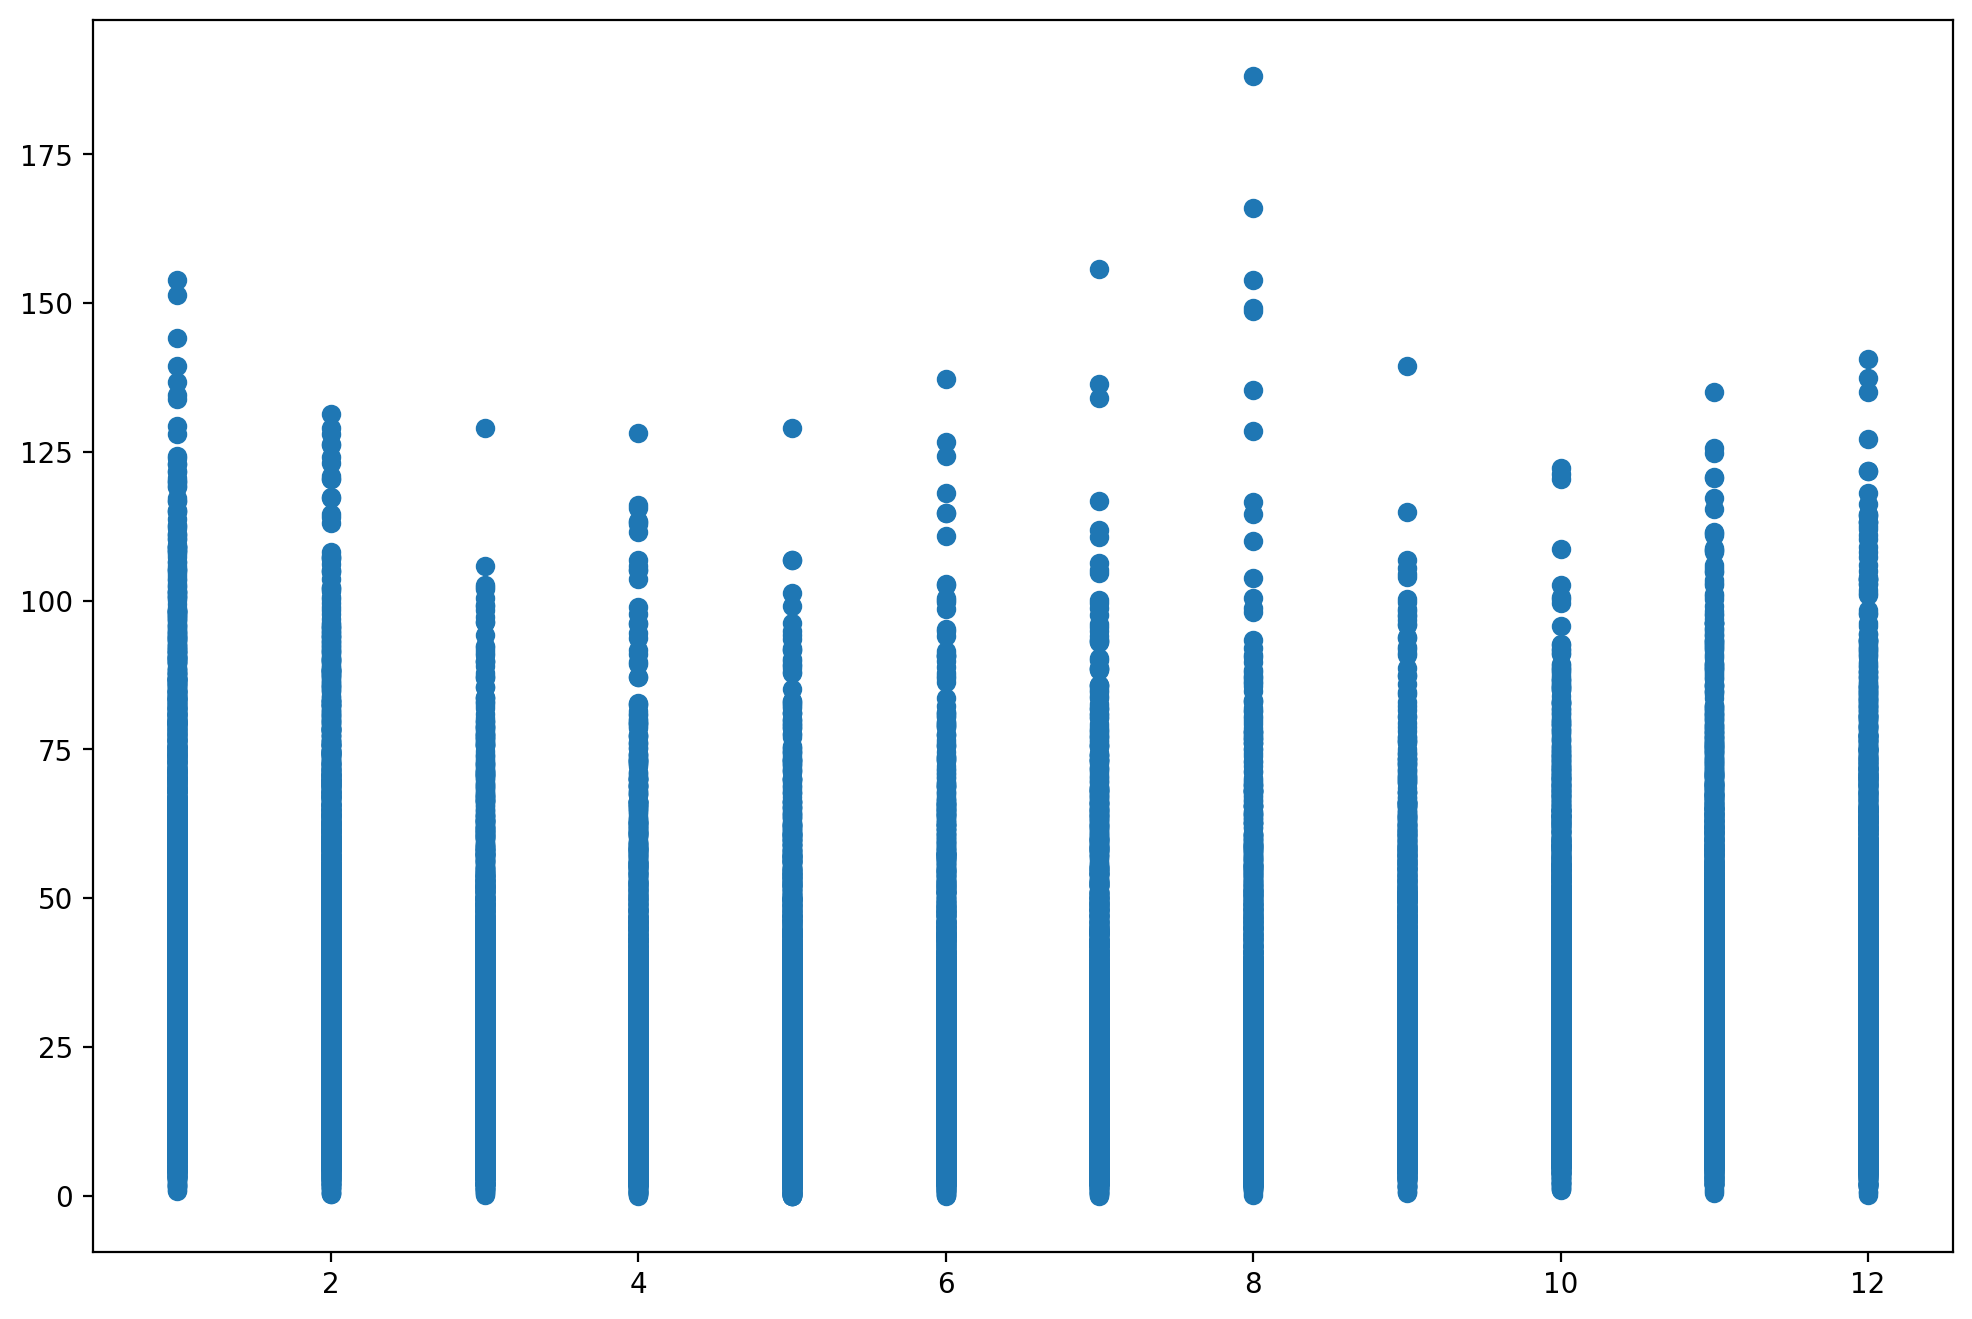

In [105]:
#NO2_Month
plt.figure(figsize=(12, 8))
plt.scatter(train["Month"],train["GT_NO2"])
plt.plot()

[]

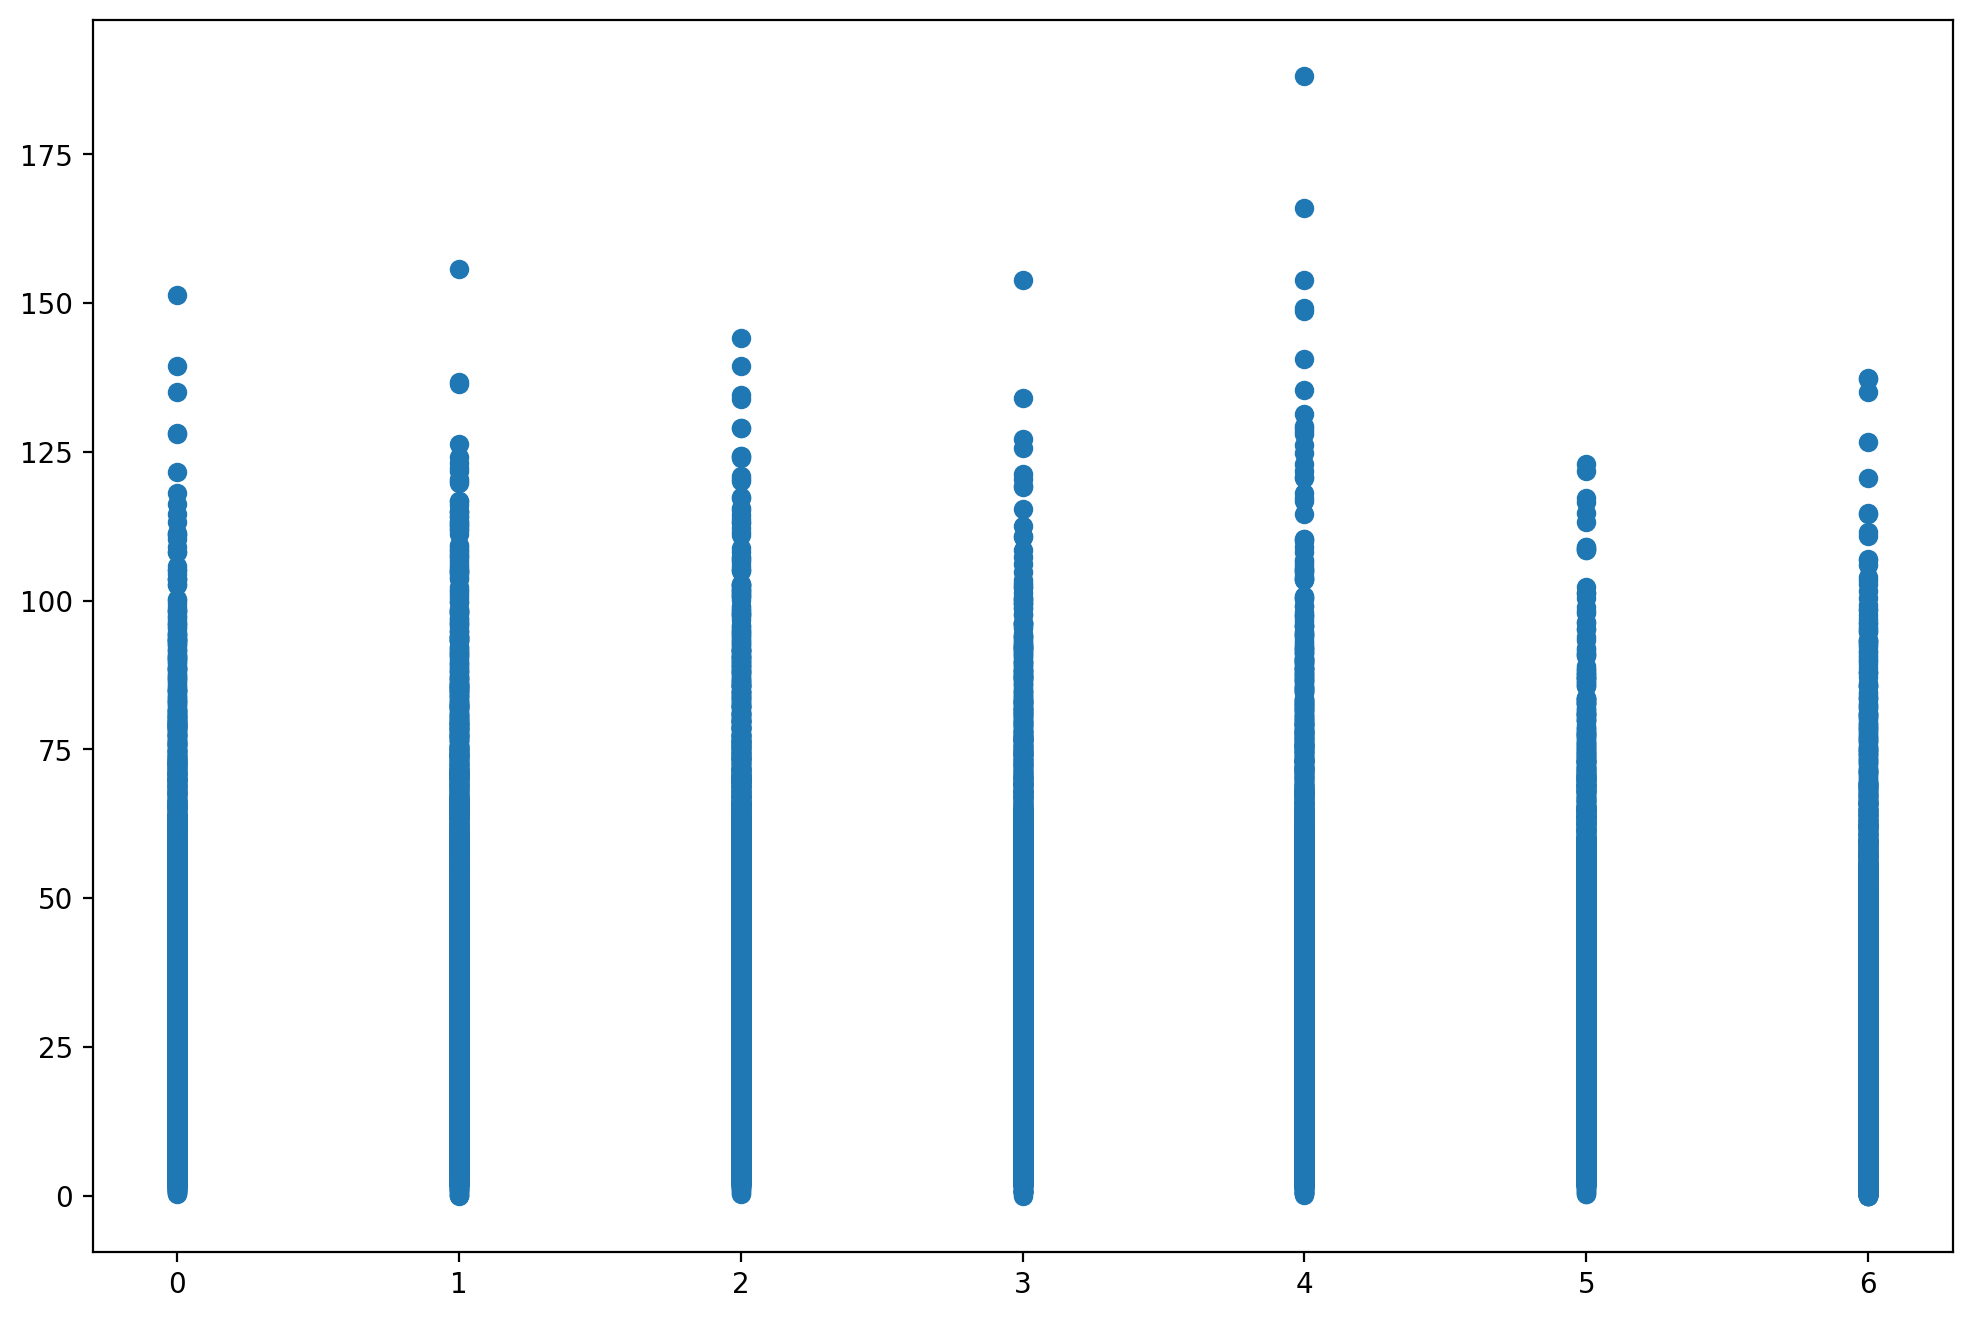

In [106]:
plt.figure(figsize=(12, 8))
plt.scatter(train["DayOfWeek"],train["GT_NO2"])
plt.plot()

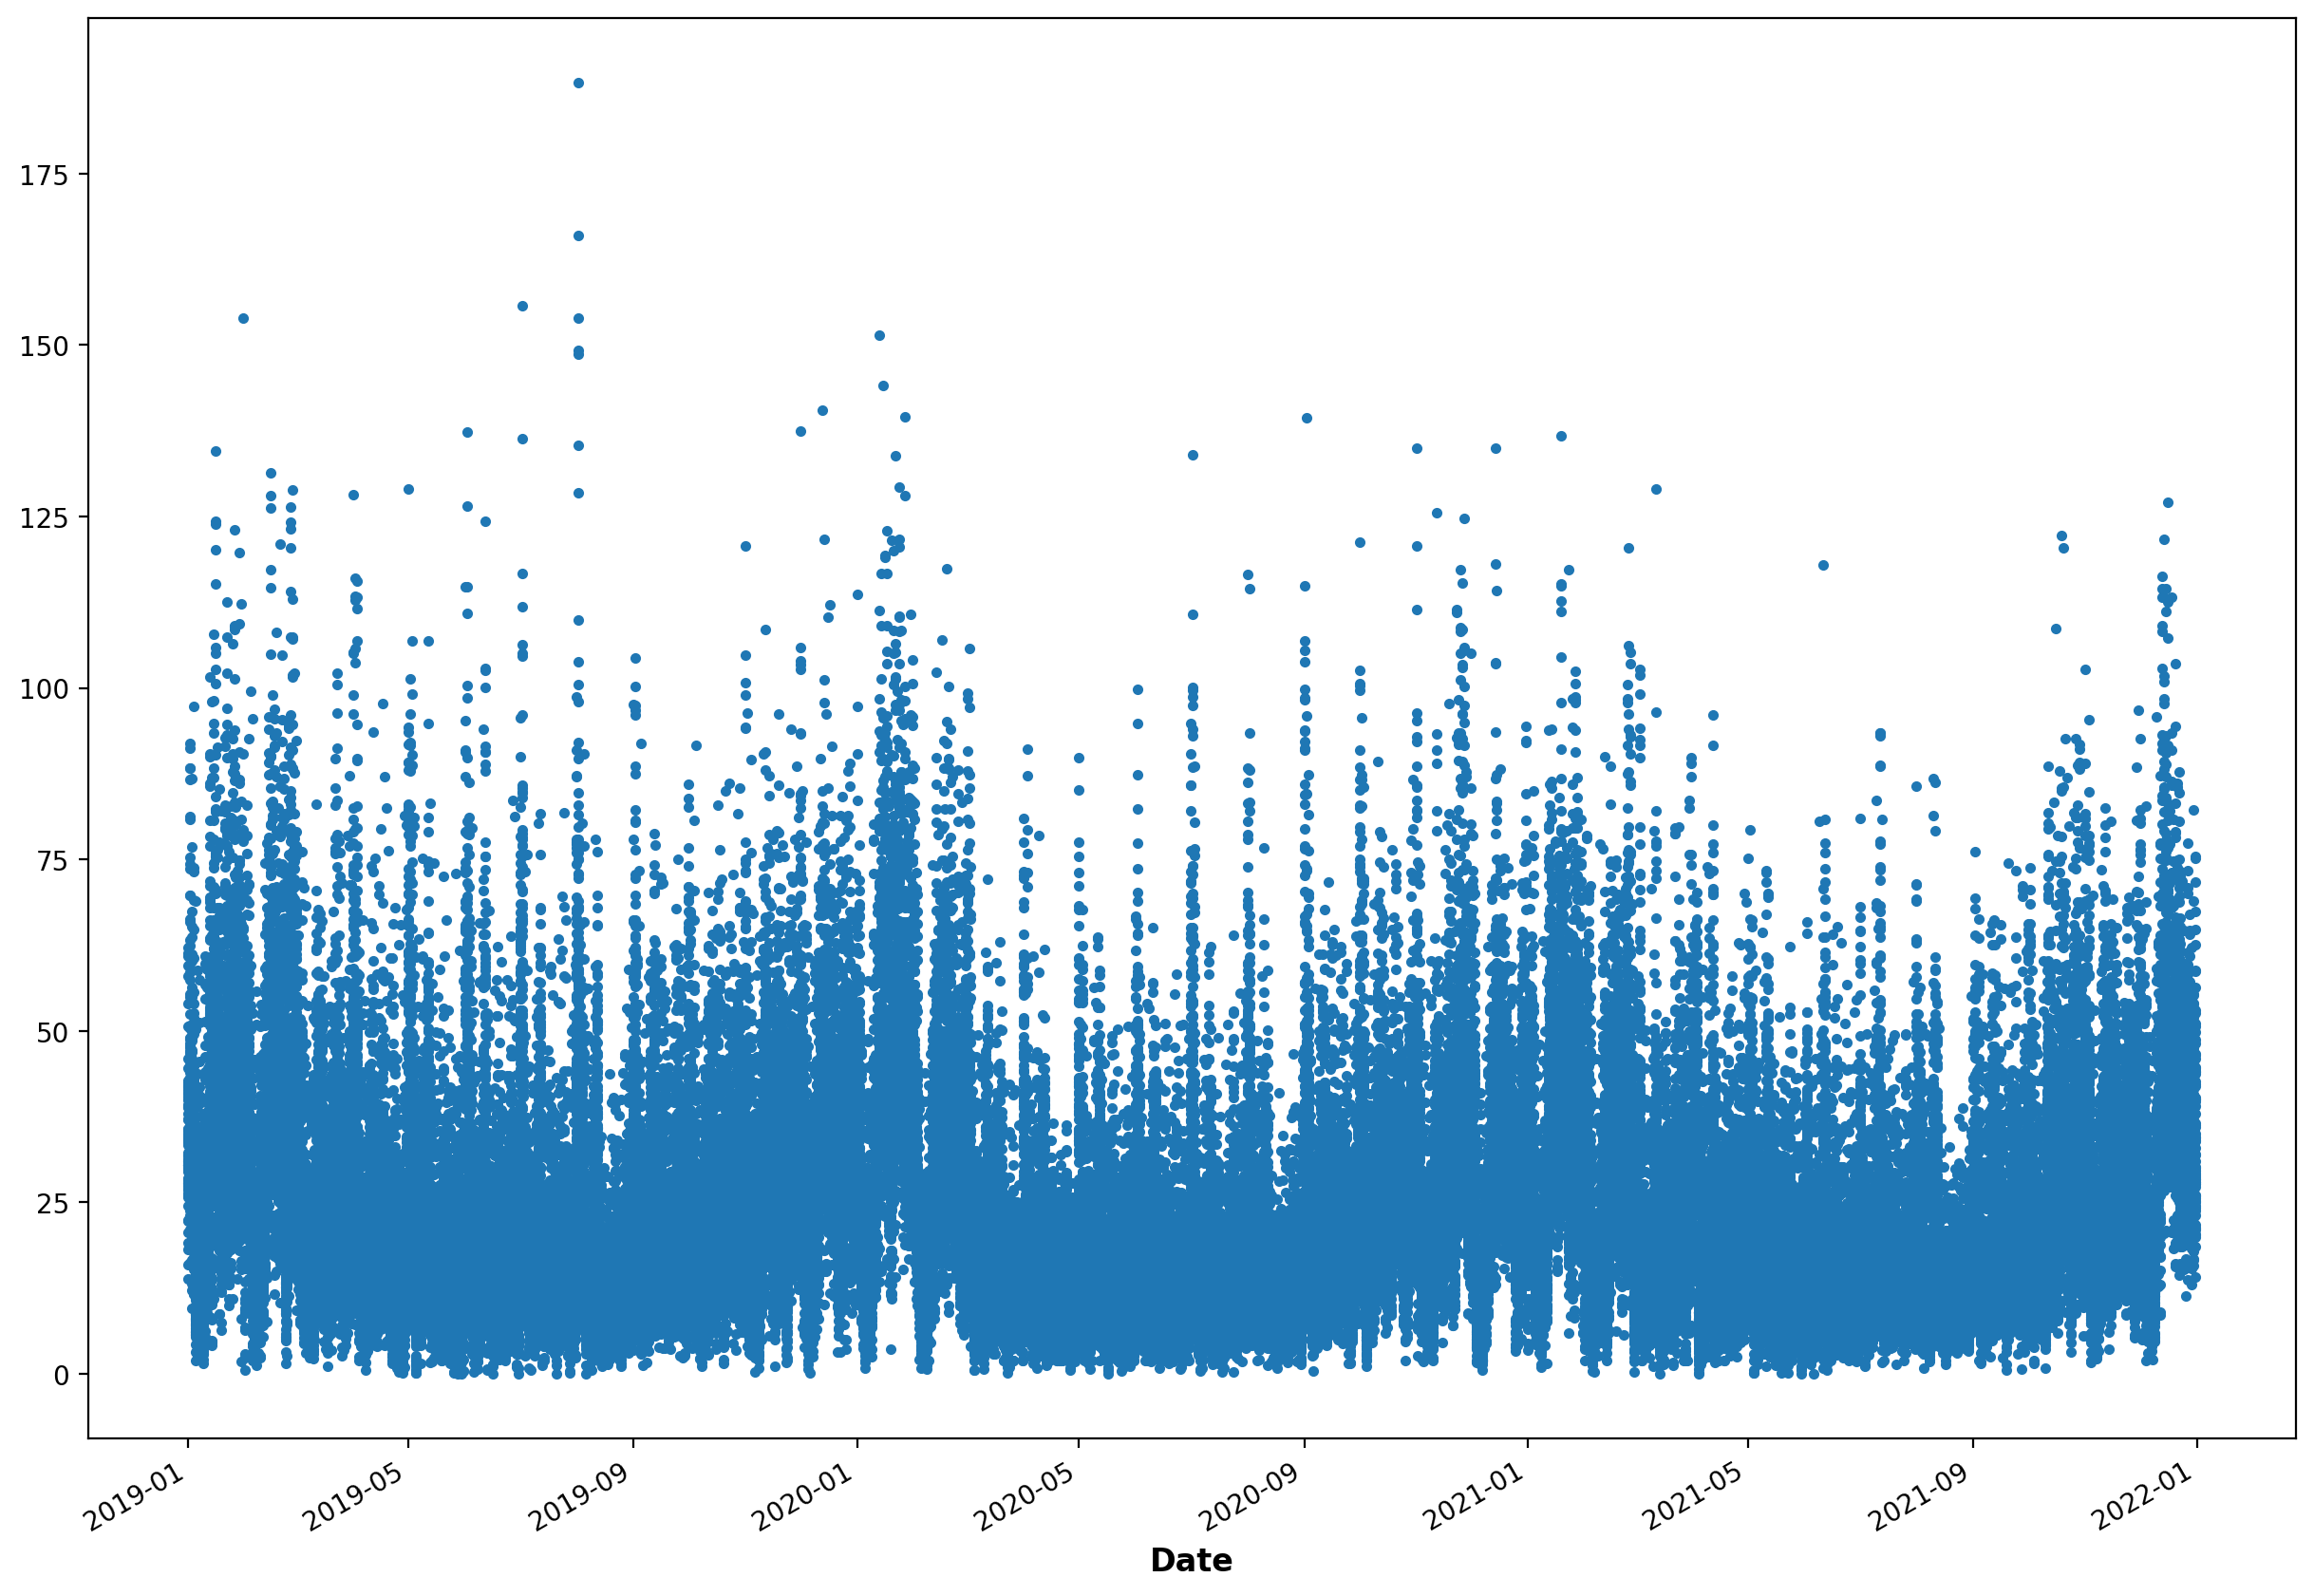

In [107]:
train['GT_NO2'].plot(style='.',figsize=(15,11))
plt.show()

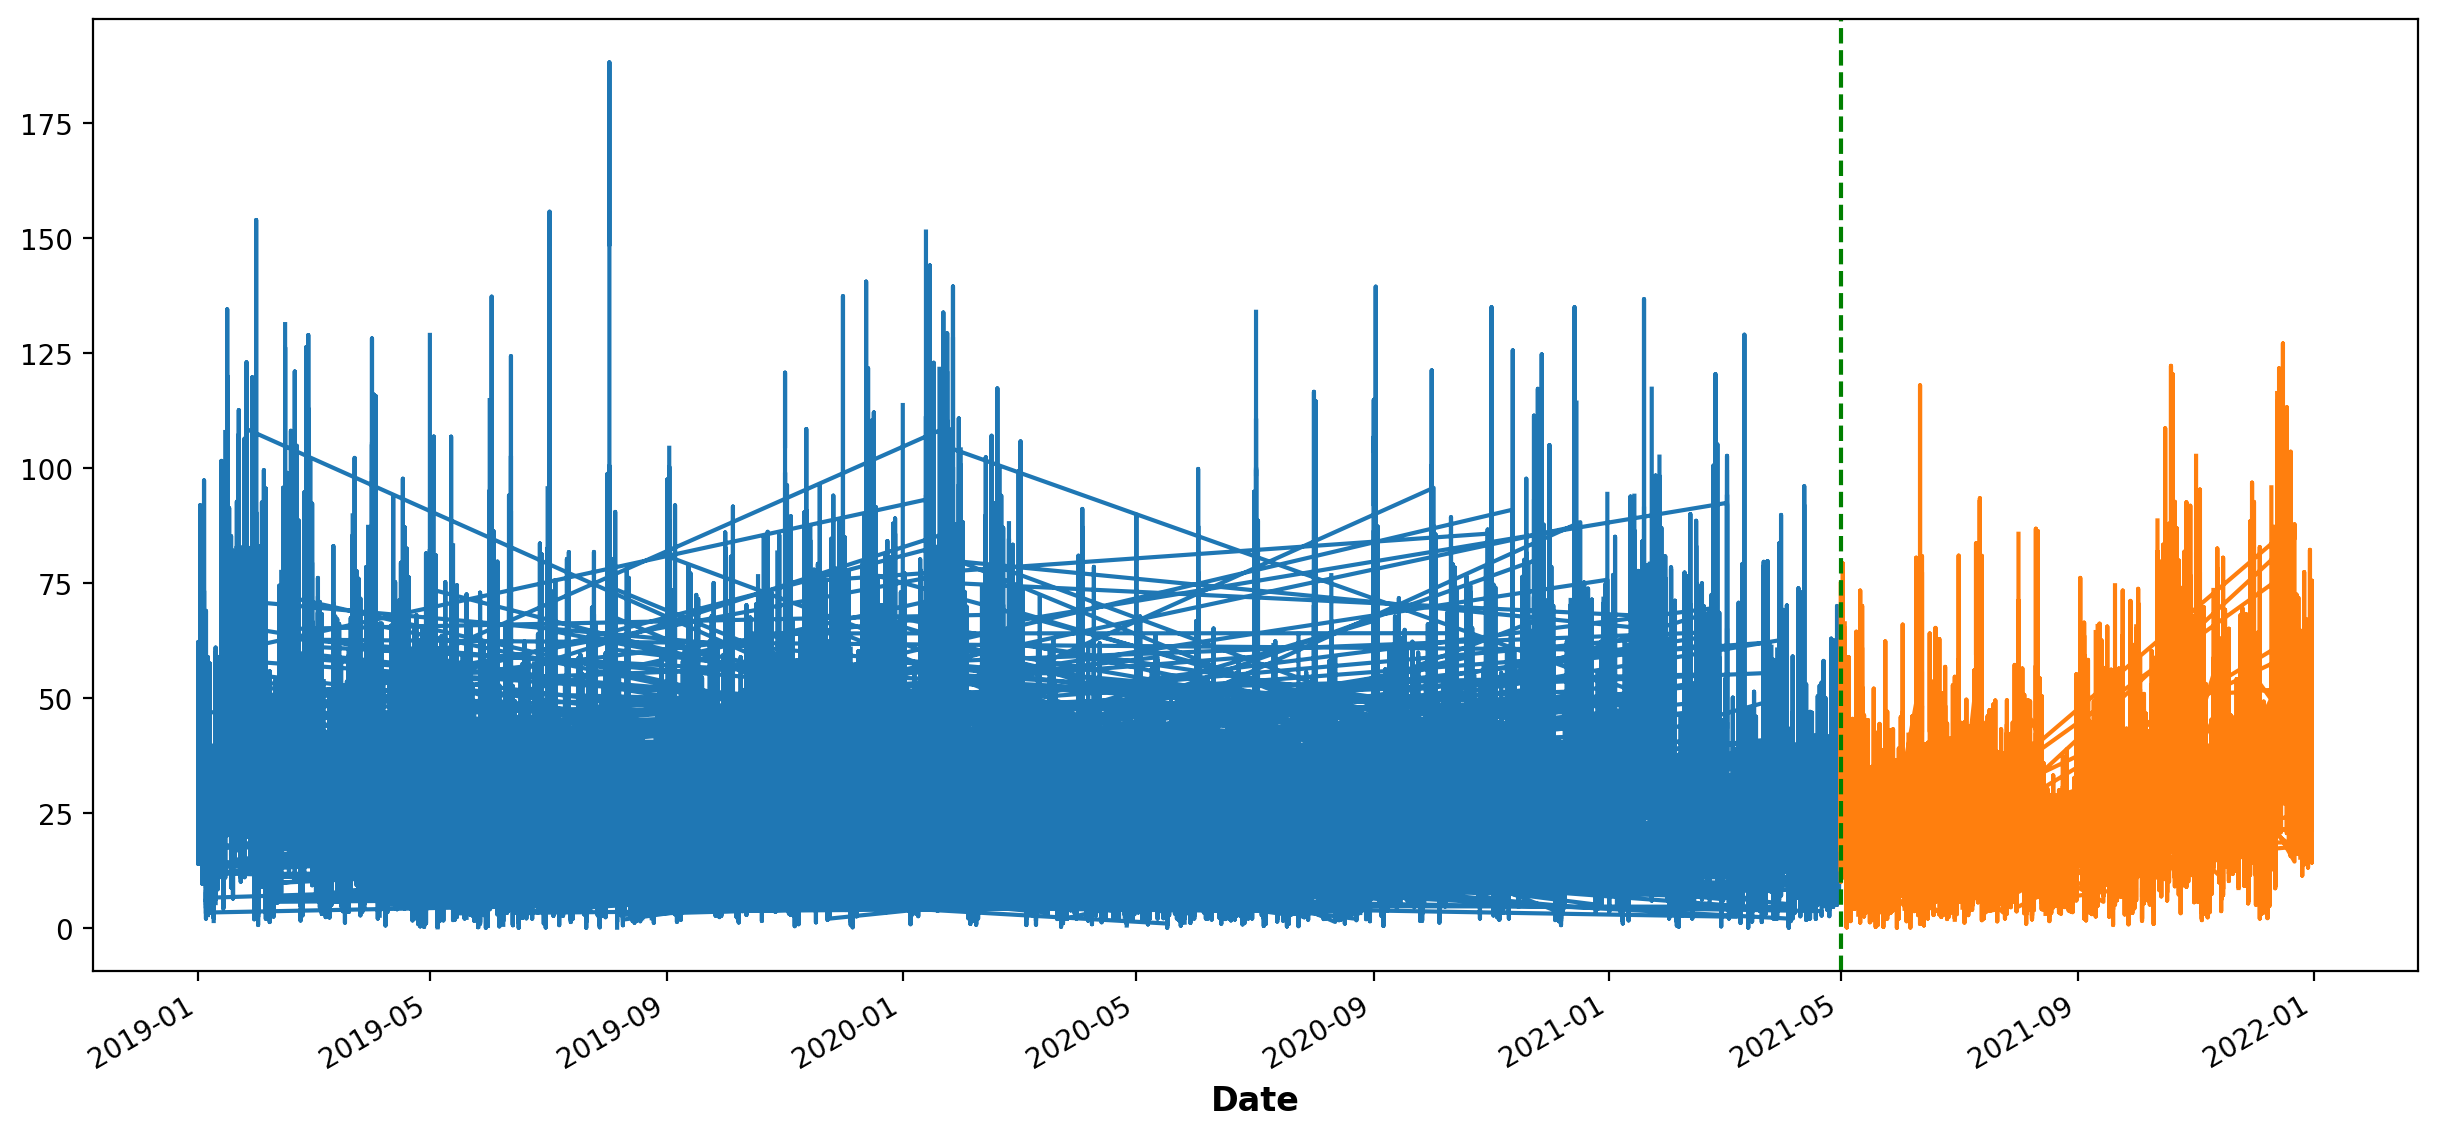

In [108]:
trainset = train.loc[train.index < '05-01-2021']
validation  =  train.loc[train.index >= '05-01-2021']
fig , ax = plt.subplots(figsize=(15,7))
trainset['GT_NO2'].plot(ax=ax, label='training_set')
validation['GT_NO2'].plot(ax=ax, label='Test_set')
ax.axvline('05-01-2021', color='green',ls='--')
plt.show()

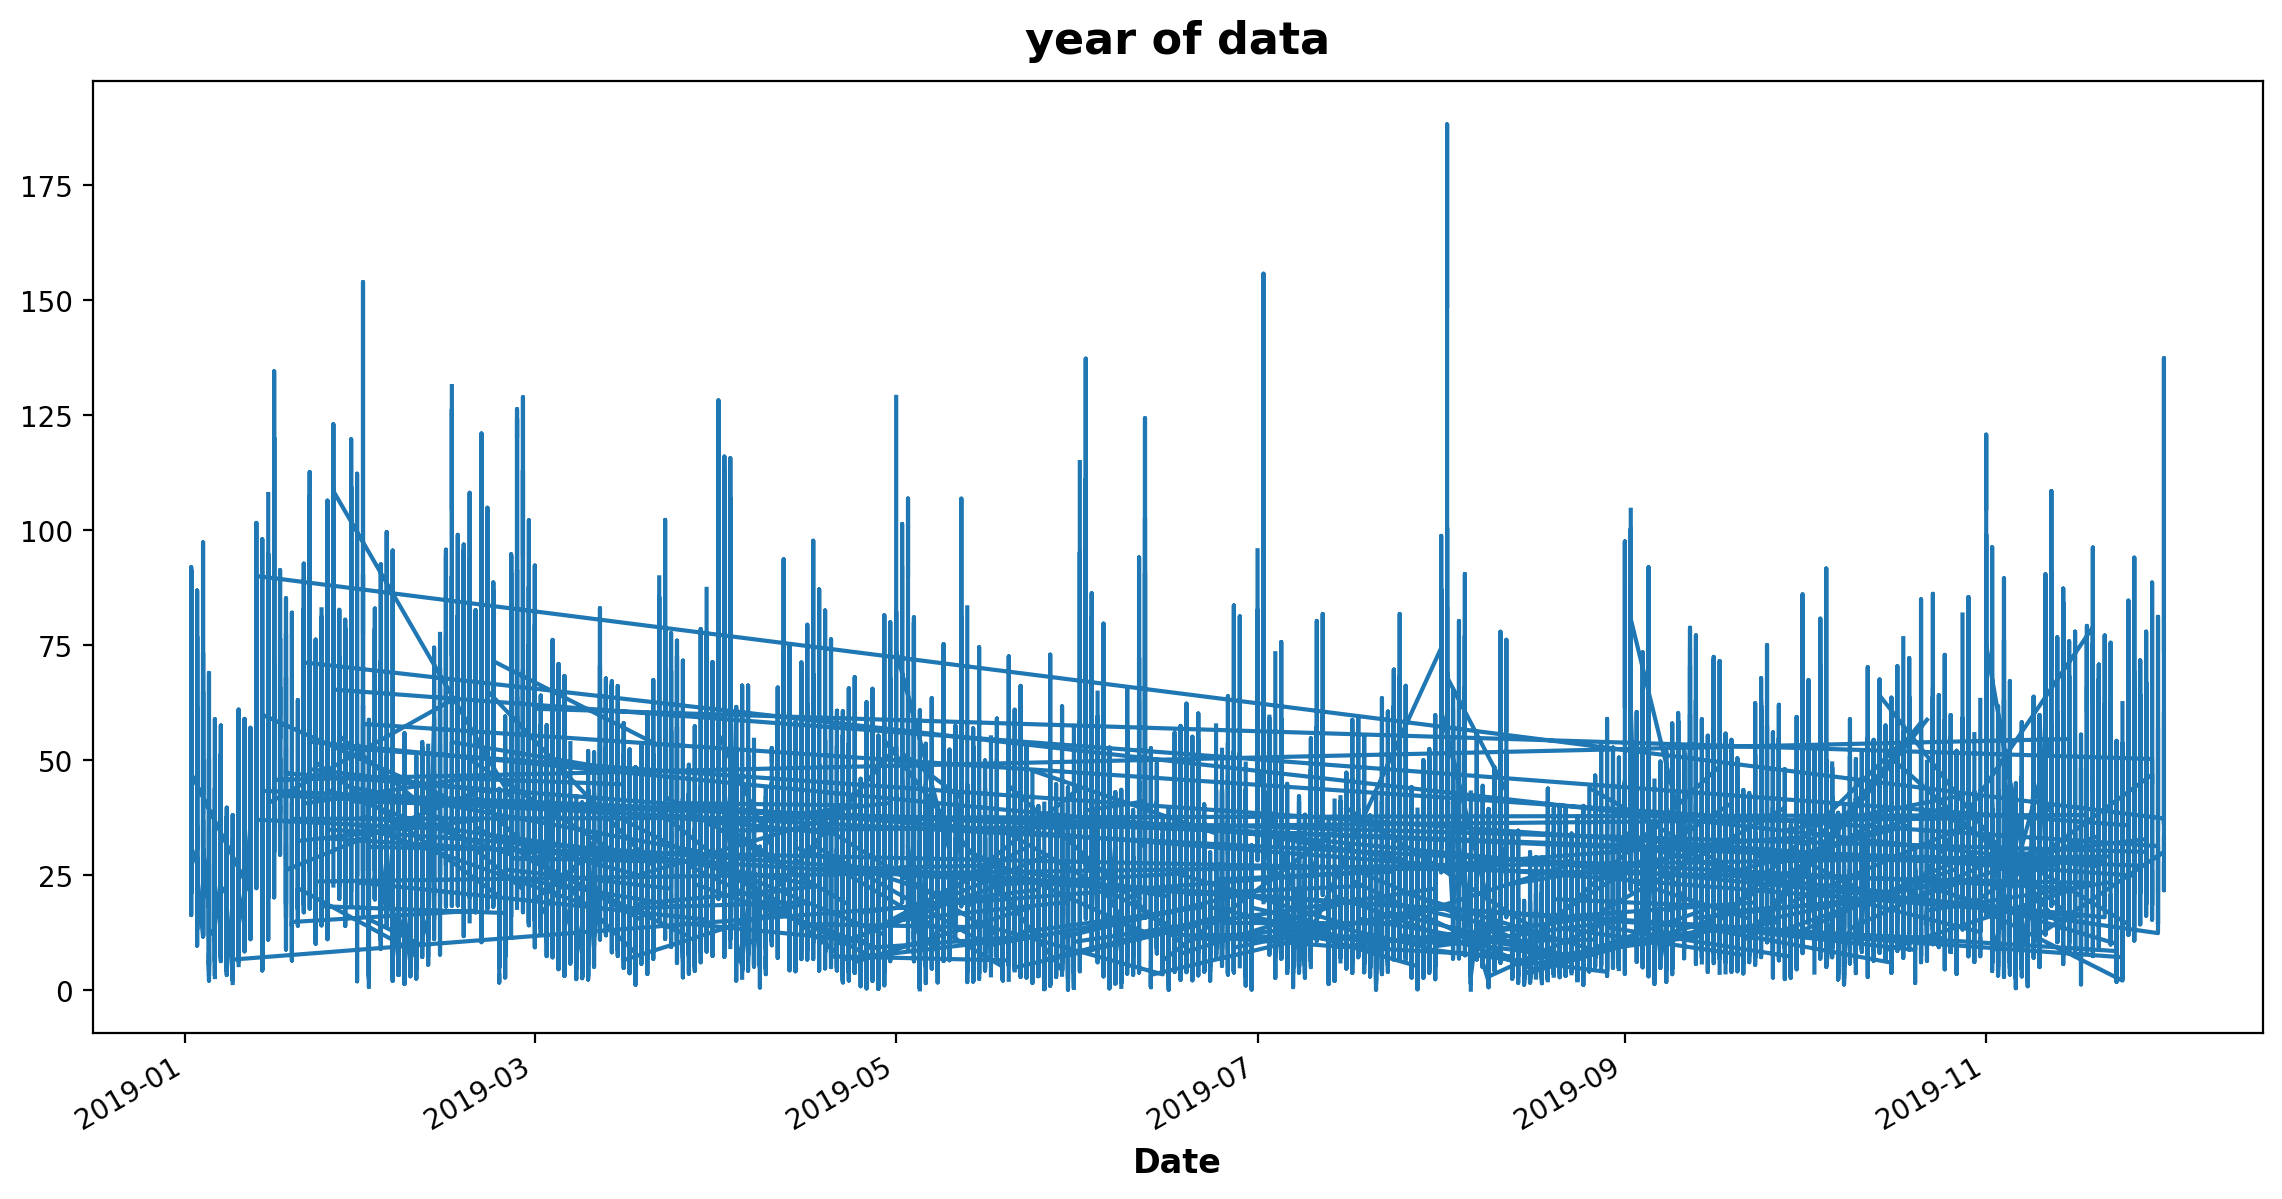

In [109]:
train['GT_NO2'].loc[((train.index > '01-01-2019') & (train.index <='12-01-2019'))].plot(figsize=(14,7), title='year of data')
plt.show()

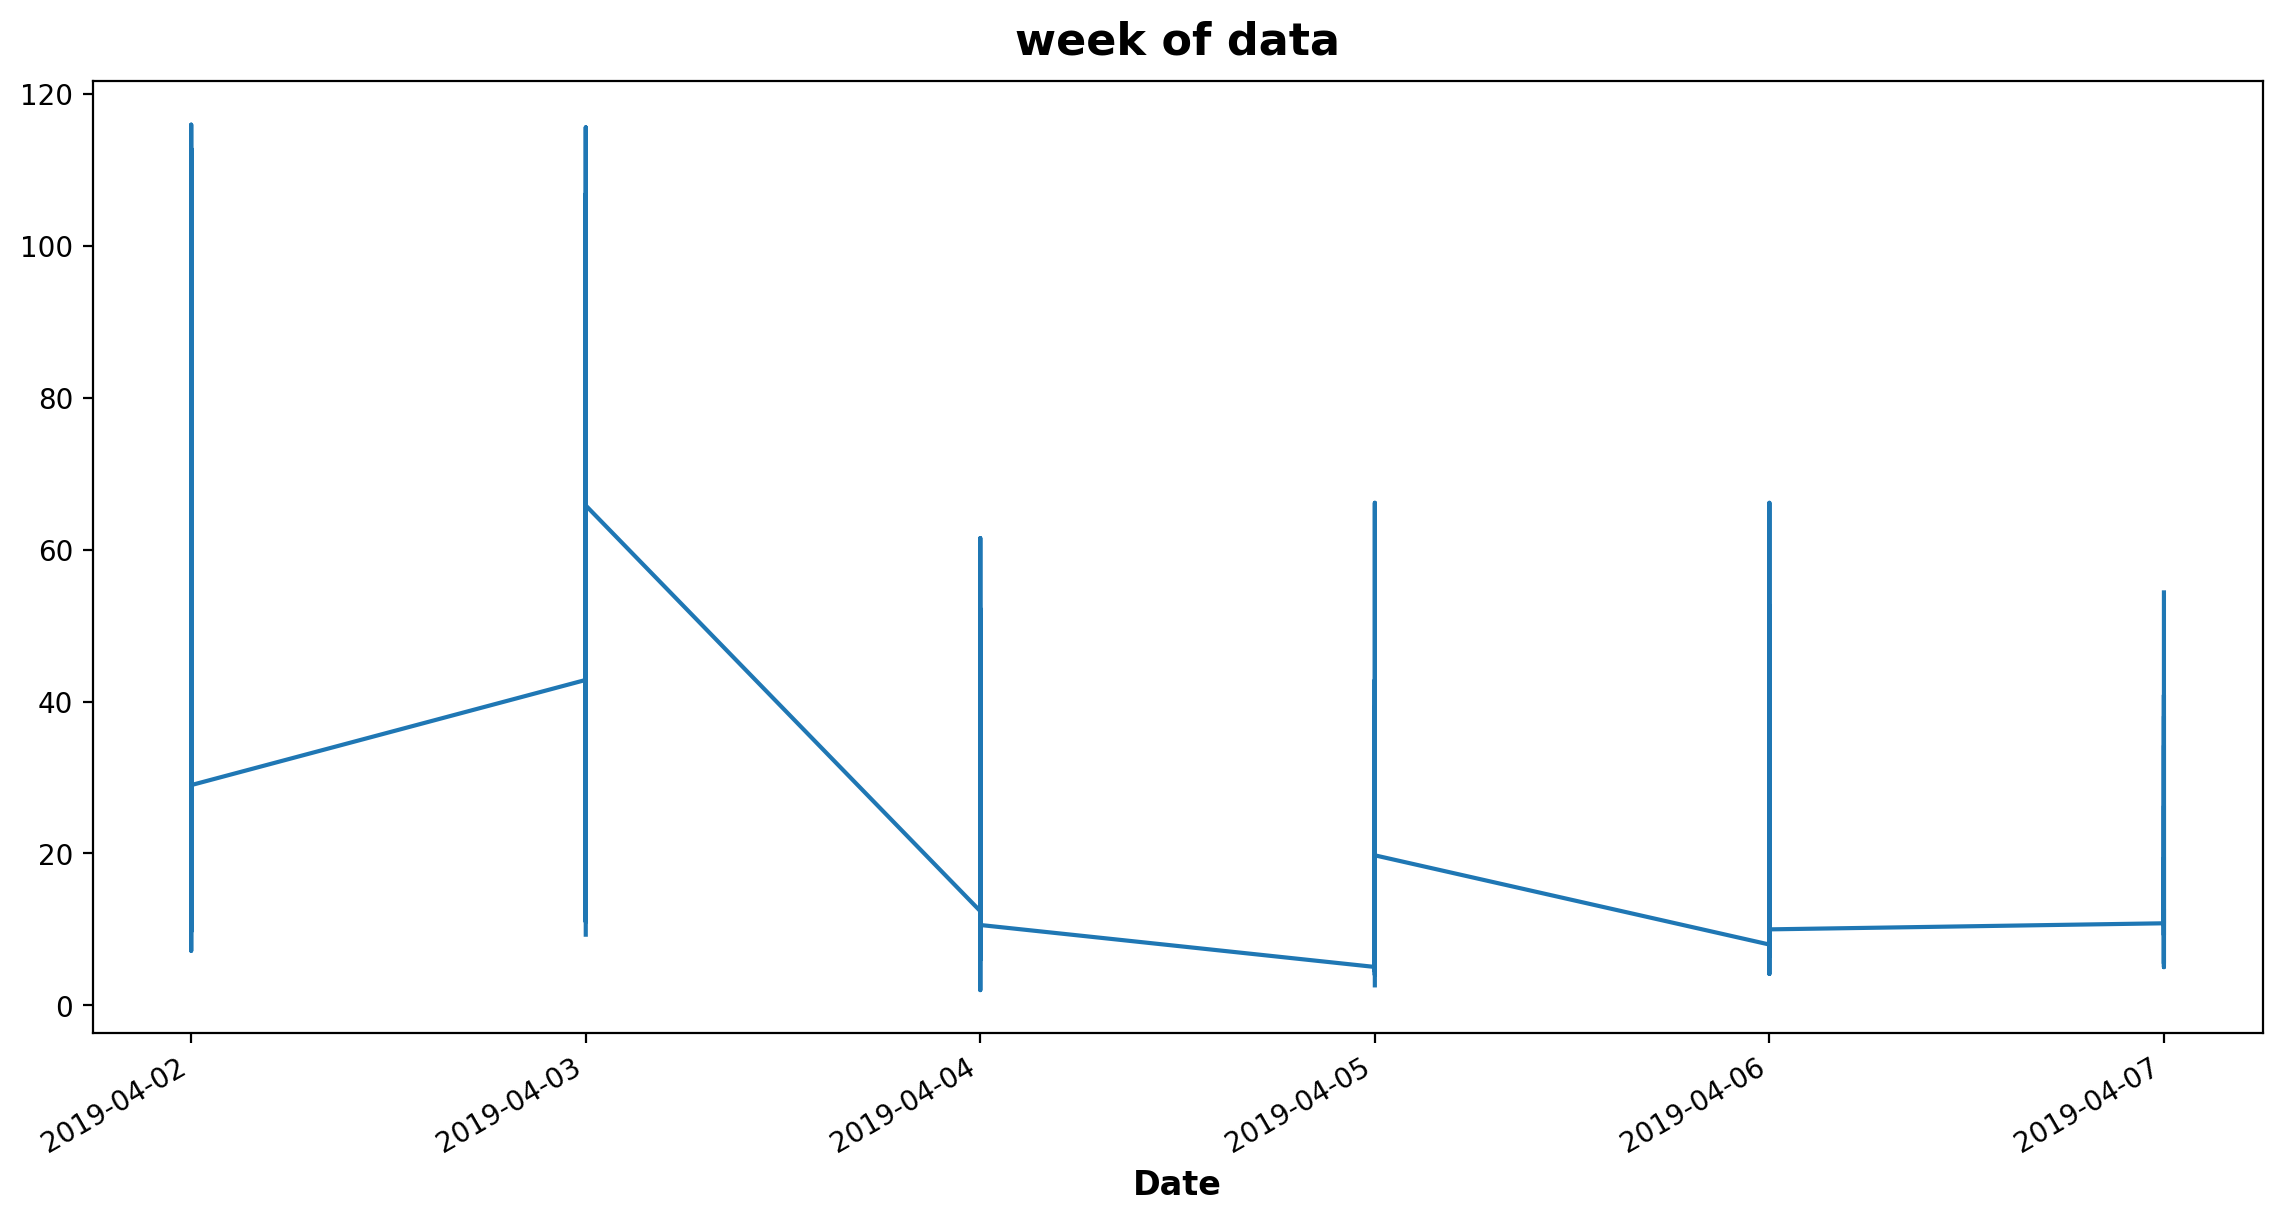

In [110]:
train['GT_NO2'].loc[(train.index > '04-01-2019') & (train.index <='04-07-2019')].plot(figsize=(14,7), title='week of data')
plt.show()

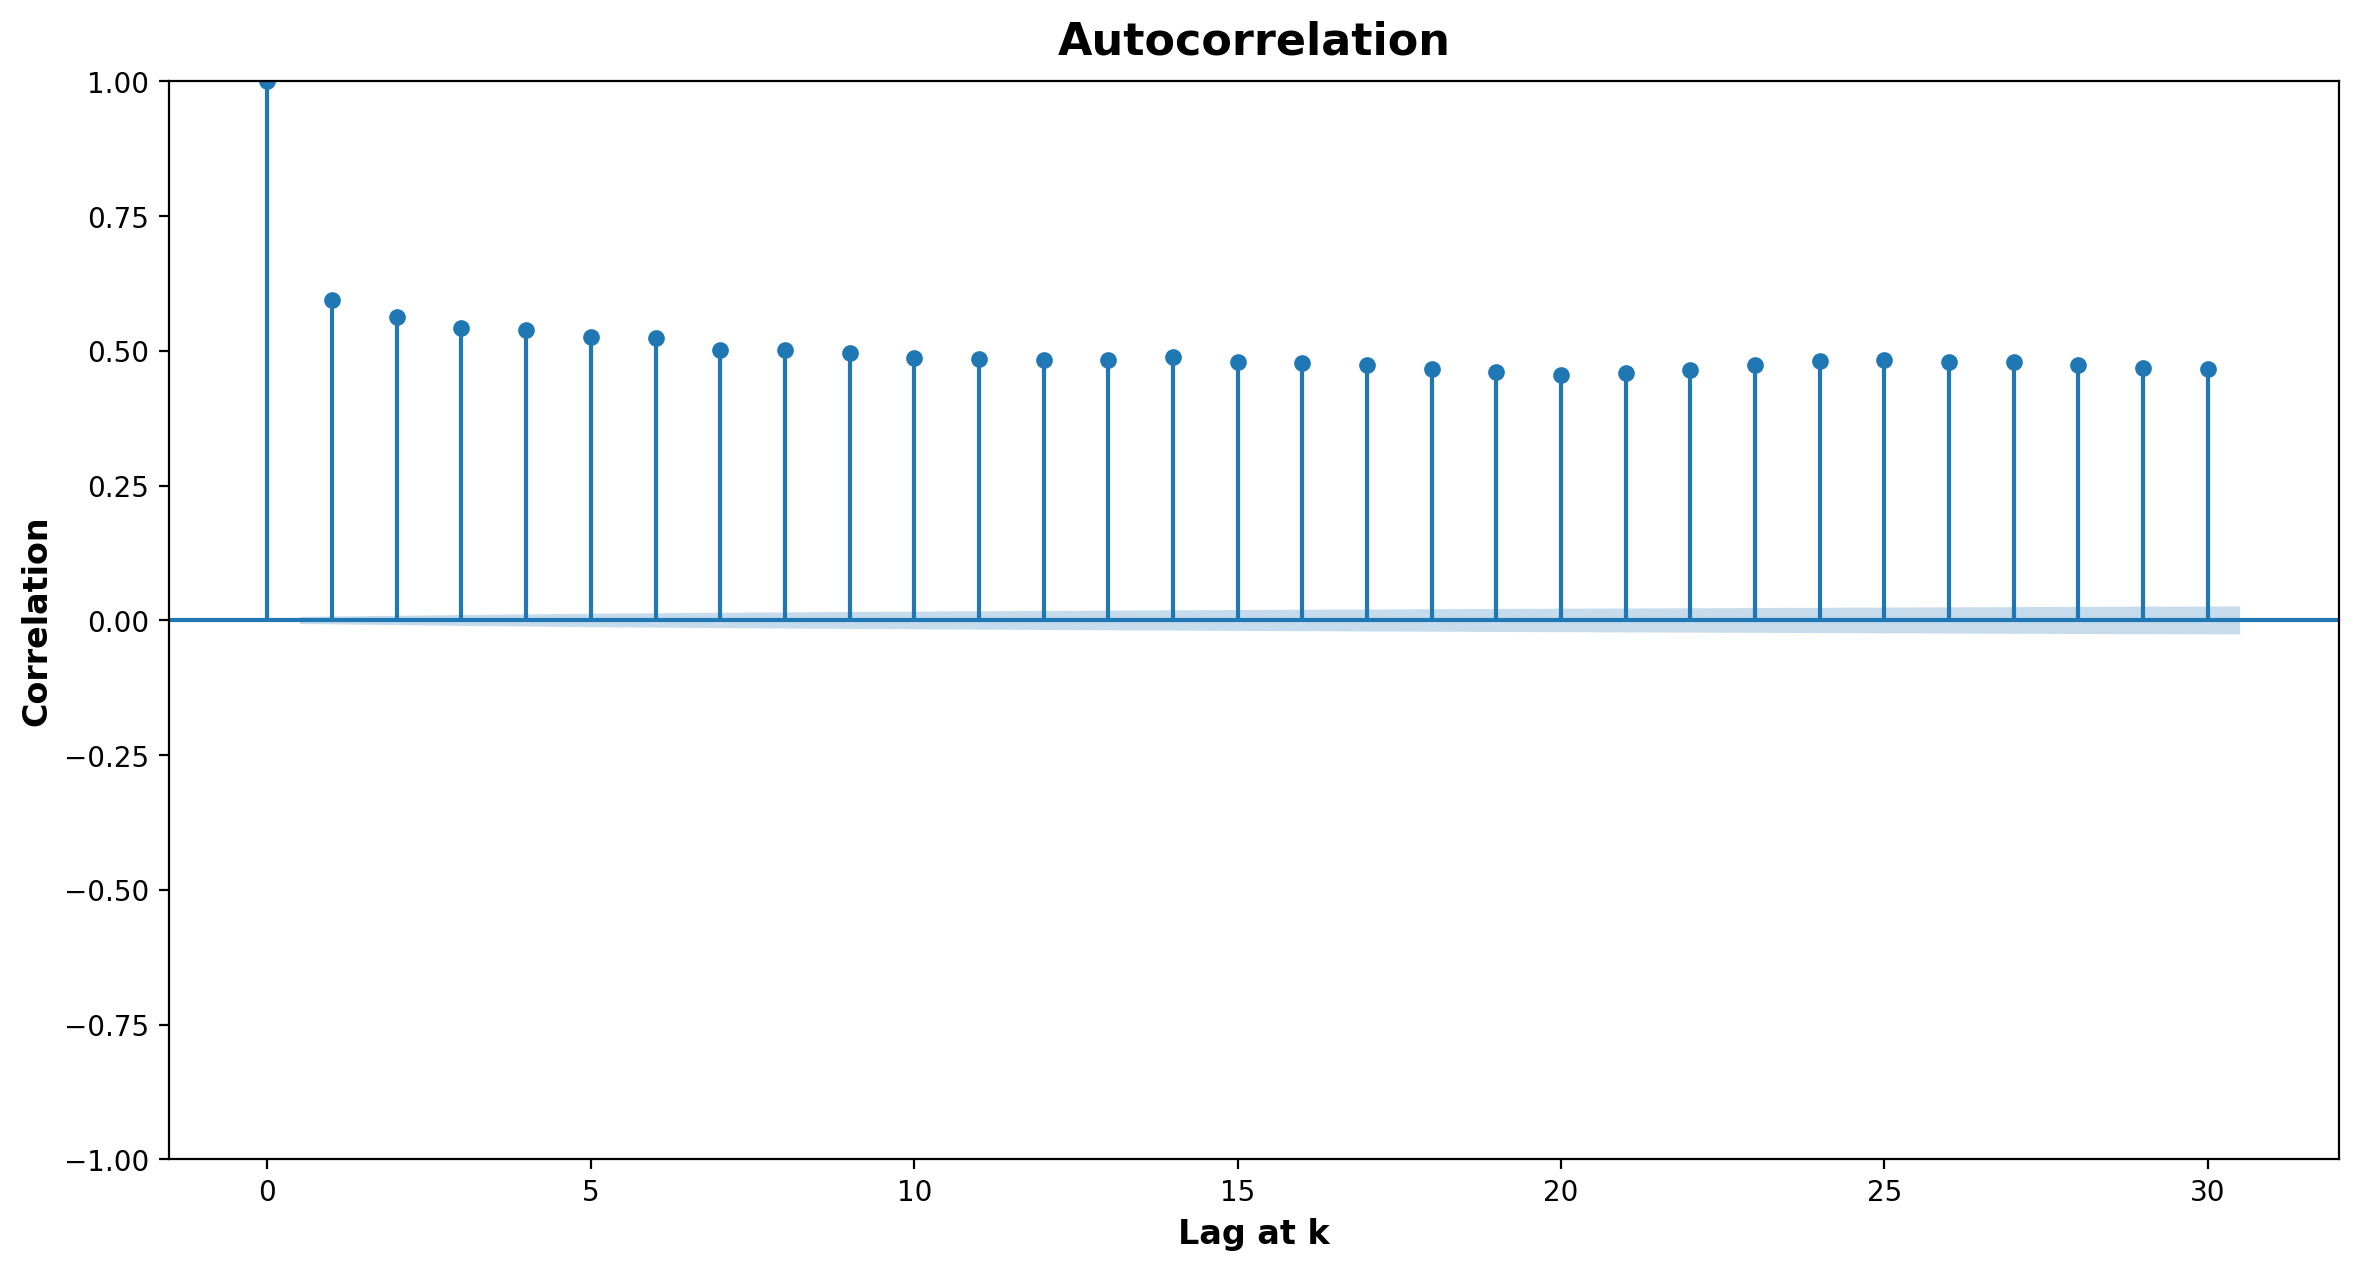

In [111]:
#AutoCorrelation Plot

rcParams["figure.figsize"] = 14, 7
fig = plot_acf(train["GT_NO2"].ffill(), lags=30)

plt.title("Autocorrelation")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
plt.show();

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_81844/3944936905.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='1/1/2019', end='1/1/2022', freq='M')


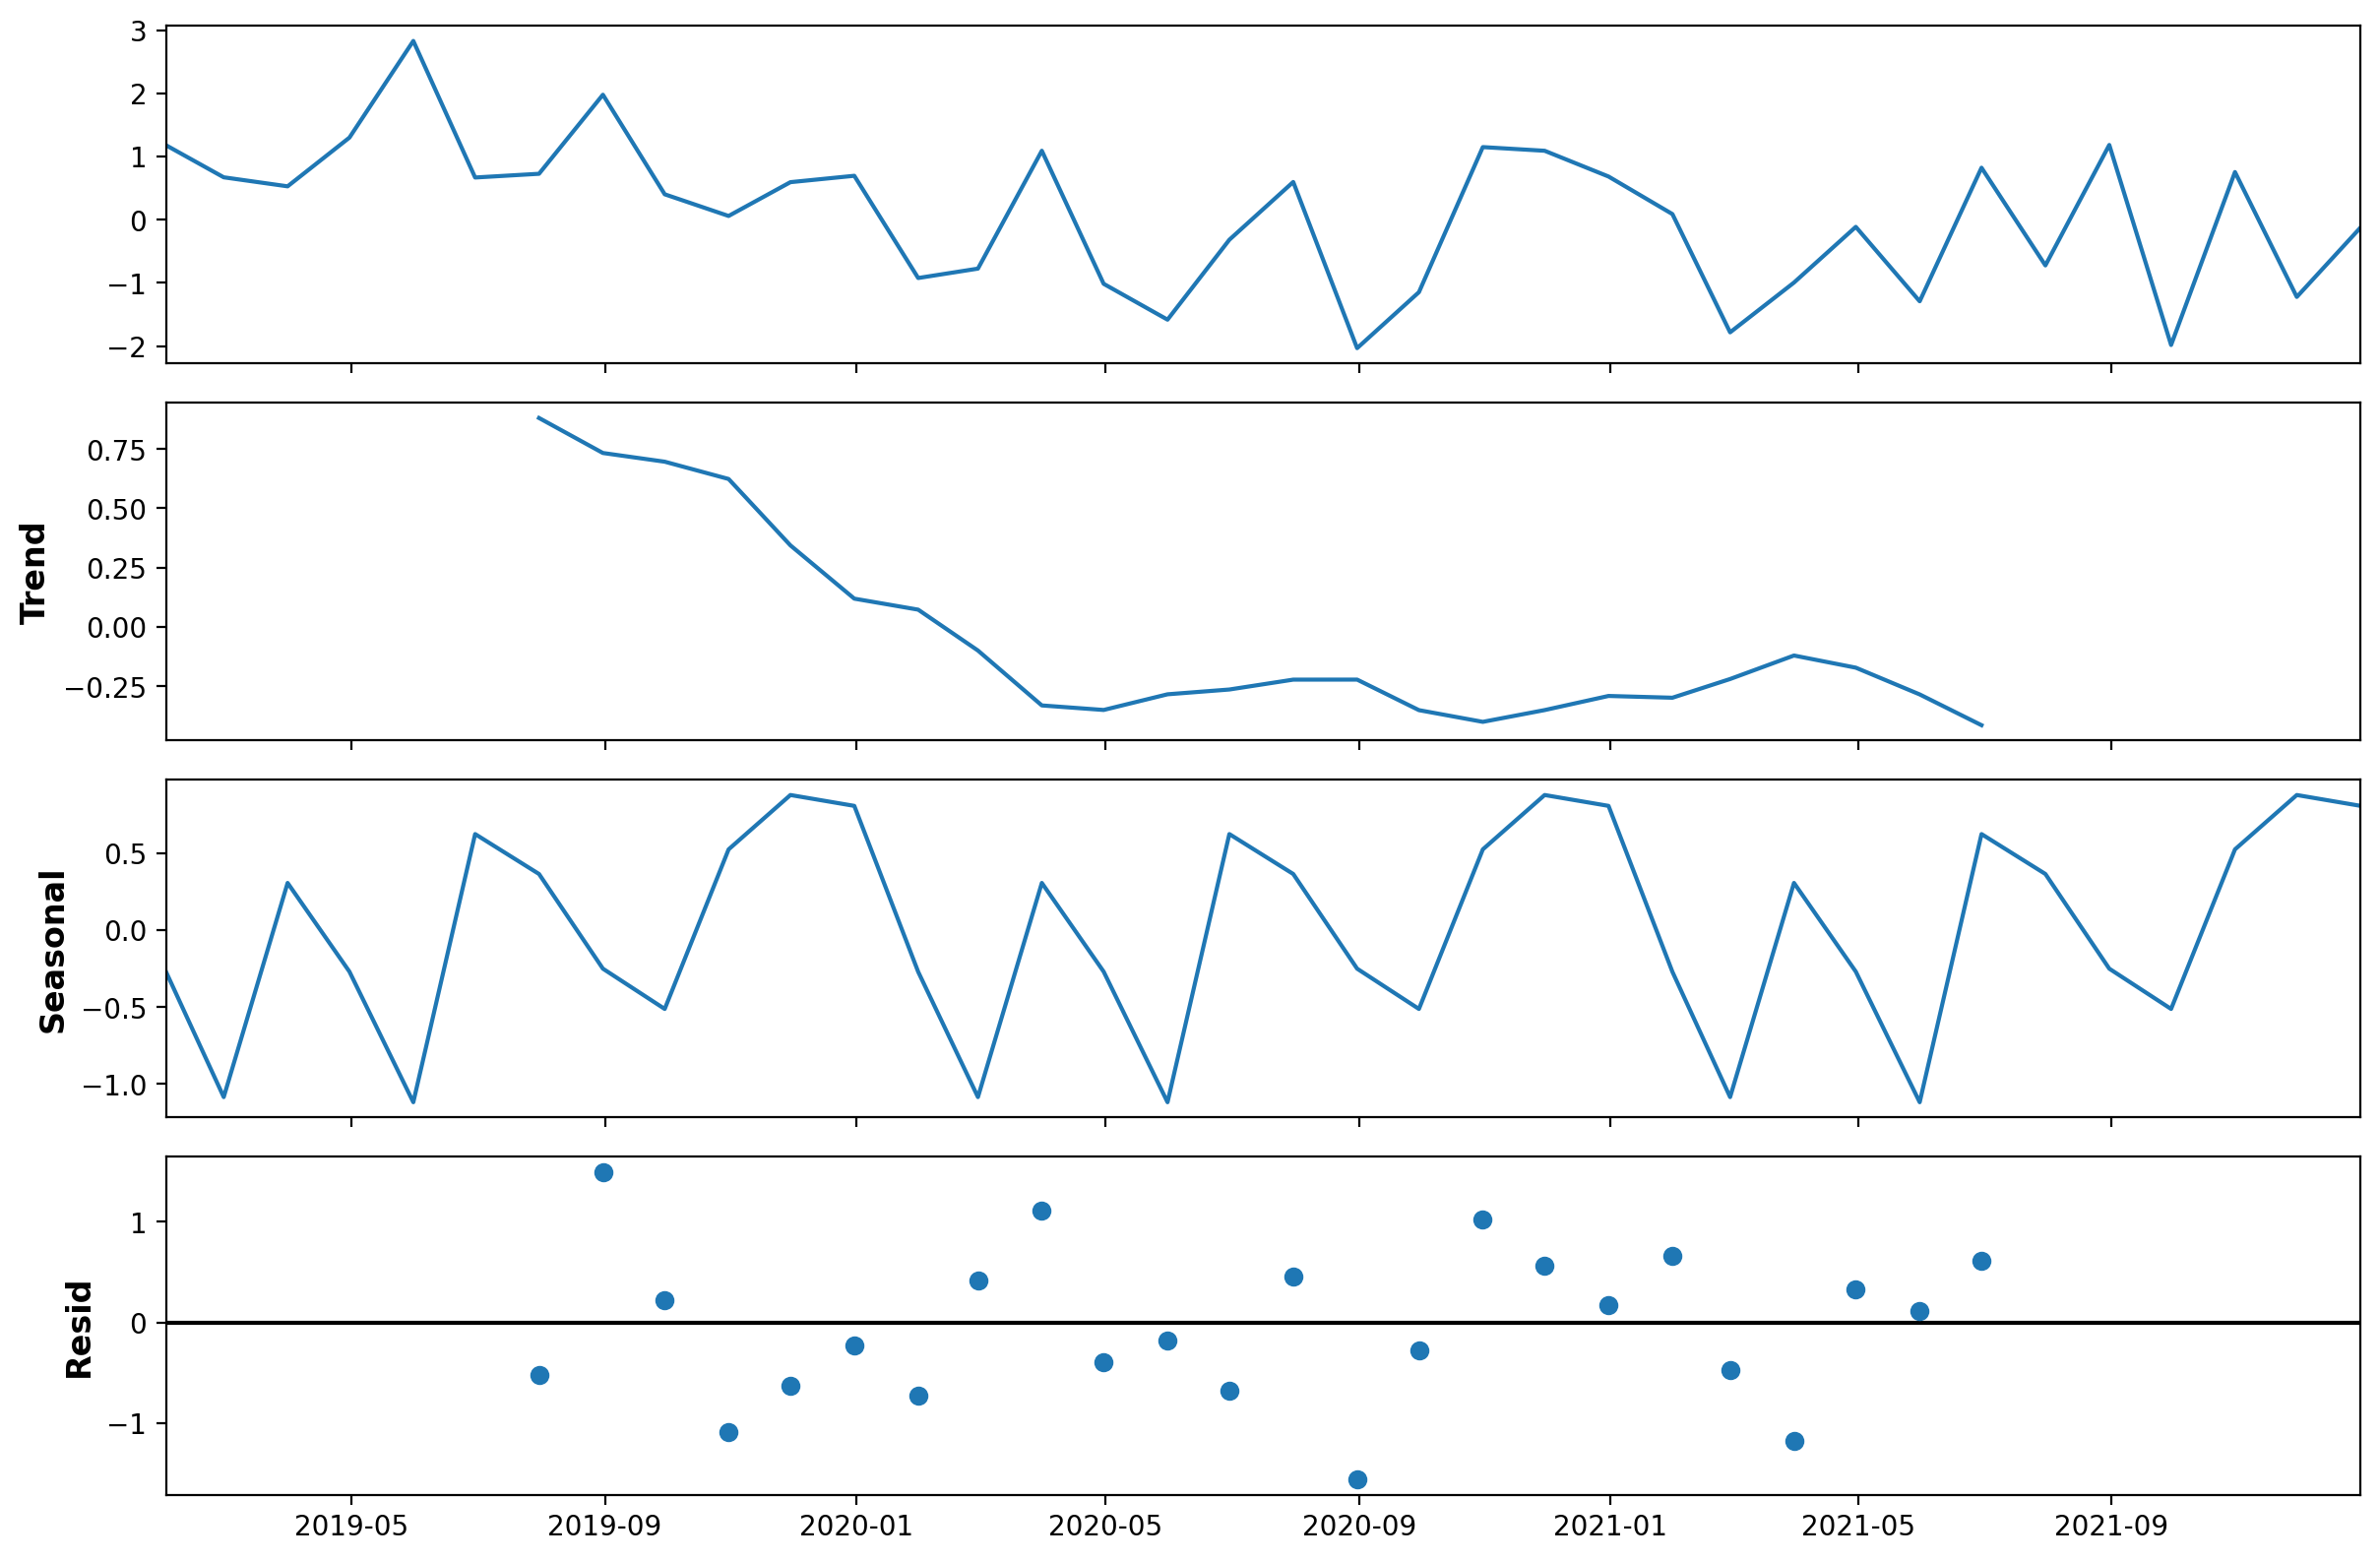

In [112]:
date_rng = pd.date_range(start='1/1/2019', end='1/1/2022', freq='M')
bio = pd.Series(np.random.randn(len(date_rng)), index=date_rng)
bio = pd.Series(bio, index=date_rng)
CFG = {'img_dim1': 12, 'img_dim2': 8}
plt.rcParams.update({'figure.figsize': (CFG['img_dim1'], CFG['img_dim2'])})
decomposition = seasonal_decompose(bio, period=12)
figure = decomposition.plot()
plt.show()

In [113]:
le = LabelEncoder()
for df in(train,test): 
    for col in df.columns: 
        if df[col].dtype == 'object': 
            df[col] = le.fit_transform(df[col])

# Missing Values & Encoding

In [114]:
"""from sklearn.impute import KNNImputer
groups = train['ID']

combined = pd.concat([train, test], keys=['train', 'test'])
imputer = KNNImputer(n_neighbors=2)
imputed_data = imputer.fit_transform(combined)
imputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)

train = imputed_df.loc['train'].reset_index(drop=True)
train = imputed_df.loc['test'].reset_index(drop=True)"""

"from sklearn.impute import KNNImputer\ngroups = train['ID']\n\ncombined = pd.concat([train, test], keys=['train', 'test'])\nimputer = KNNImputer(n_neighbors=2)\nimputed_data = imputer.fit_transform(combined)\nimputed_df = pd.DataFrame(imputed_data, columns=combined.columns, index=combined.index)\n\ntrain = imputed_df.loc['train'].reset_index(drop=True)\ntrain = imputed_df.loc['test'].reset_index(drop=True)"

# CV and Modeling

In [115]:
groups = train['ID']
model =  LGBMRegressor(random_state=7)
n_splits = 5
n = train['GT_NO2'].count()
num_bins = int(1 + np.log2(n))
train['GT_NO2_bins'] = pd.cut(train['GT_NO2'], bins=num_bins, labels=False)
#test['GT_NO2_bins'] = pd.cut(test['GT_NO2'], bins=num_bins, labels=False)

In [116]:
model = LGBMRegressor(random_state=7)
n_splits = 4
cv = GroupKFold(n_splits=n_splits)

def validate(trainset, testset, target_col):

    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_squared_error(valid_testset, valid_pred, squared=False)
    print('score:', score)
    
    return score
stds = []
rmse = []

for train_idx, test_idx in cv.split(train.drop(columns='GT_NO2'), train['GT_NO2'], groups=groups):
    train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
    stds.append(test_v['GT_NO2'].std())
    rmse.append(validate(train_v, test_v, 'GT_NO2'))

print('RMSE:', np.array(rmse).mean())
print('RMSE std:', np.array(rmse).std())
print('Standard Deviations:', stds)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002286 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4290
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 25
[LightGBM] [Info] Start training from score 24.434701
std: 14.844616530580991
score: 2.832232707931784
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4290
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 25
[LightGBM] [Info] Start training from score 22.752866


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 19.095801921081847
score: 2.983500479700525
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4294
[LightGBM] [Info] Number of data points in the train set: 64664, number of used features: 25
[LightGBM] [Info] Start training from score 22.615852


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 18.147840185499298
score: 2.9061713611179583
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4296
[LightGBM] [Info] Number of data points in the train set: 65760, number of used features: 25
[LightGBM] [Info] Start training from score 23.199636


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


std: 15.385929166349635
score: 2.9053576535170733
RMSE: 2.906815550566835
RMSE std: 0.05349233406670891
Standard Deviations: [np.float64(14.844616530580993), np.float64(19.095801921081847), np.float64(18.147840185499298), np.float64(15.385929166349637)]


/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [117]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
#sub_df.to_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/submissions/submission8300738760020405.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4346
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 25
[LightGBM] [Info] Start training from score 23.250548


ValueError: Number of features of the model must match the input. Model n_features_ is 25 and input n_features is 23

In [ ]:
model.fit(train.drop(columns='GT_NO2'),train['GT_NO2'])
y_pred = model.predict(test)
sub_df = pd.DataFrame({'id': test_id,'GT_NO2':y_pred})
sub_df.to_csv('/Users/ahmed/Downloads/computerscience/Kaggle/geoai-ground-level-no2-estimation/geoai-ground/submissions/submission11314985626750522.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6124
[LightGBM] [Info] Number of data points in the train set: 86584, number of used features: 48
[LightGBM] [Info] Start training from score 23.250548


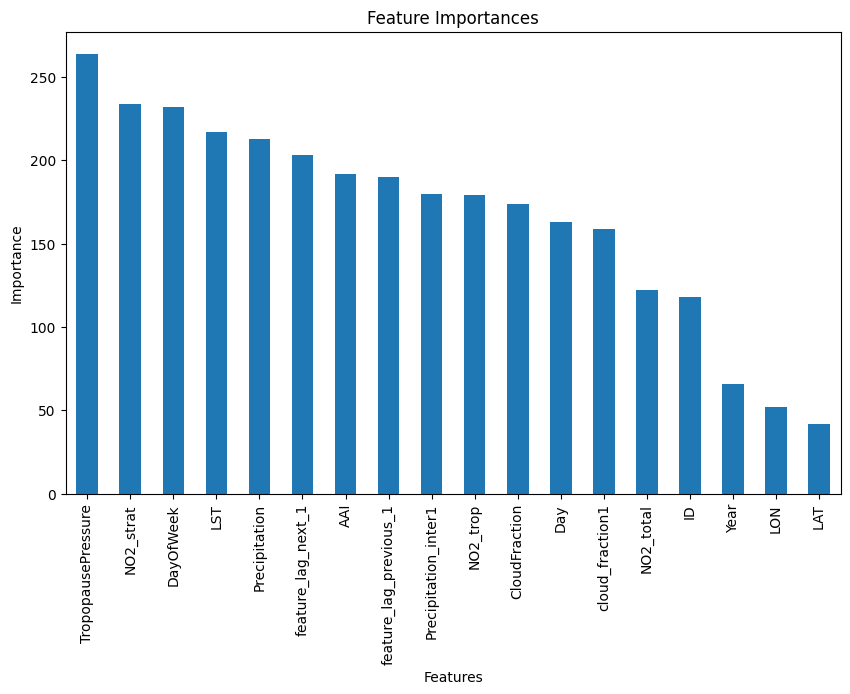

In [ ]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [6]:
import pandas as pd
import sklearn.preprocessing 
data = pd.DataFrame({'name': ['Ahmed', 'Hassan' , 'Omer'], 'Class': ['P','A', 'C']})
dum  = pd.get_dummies(data['Class'])
print(dum)

       A      C      P
0  False  False   True
1   True  False  False
2  False   True  False
